# Changes:
1. Create a Pytorch Dataloader
2. Normalize input
3. Make the code runnable on Google Colab

In [1]:
!pip install torch torchvision

    100% |████████████████████████████████| 519.5MB 30kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x59b6e000 @  0x7f3a39cbf1c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8
    100% |████████████████████████████████| 61kB 2.1MB/s 
    100% |████████████████████████████████| 2.0MB 2.9MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [2]:
!pip install imageio

    100% |████████████████████████████████| 3.3MB 7.8MB/s 


In [3]:
! git clone https://github.com/allen-q/pytorch-learning.git

Cloning into 'pytorch-learning'...
remote: Counting objects: 746, done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 746 (delta 8), reused 14 (delta 5), pack-reused 721
Receiving objects: 100% (746/746), 284.70 MiB | 25.64 MiB/s, done.
Resolving deltas: 100% (277/277), done.


In [4]:
cd pytorch-learning/kaggle/salt/

/content/pytorch-learning/kaggle/salt


In [0]:
#!wget https://github.com/allen-q/pytorch-learning/raw/master/kaggle/salt/data/np_test_0.npy

In [0]:
#!wget https://github.com/allen-q/pytorch-learning/raw/master/kaggle/salt/data/np_test_1.npy

In [0]:
#!wget https://github.com/allen-q/pytorch-learning/raw/master/kaggle/salt/data/np_train_all.npy

In [0]:
#!wget https://github.com/allen-q/pytorch-learning/raw/master/kaggle/salt/data/np_train_all_mask.npy

In [0]:
import zipfile
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from skimage import io, transform
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as ply
import os
import imageio
from PIL import Image
import glob
import matplotlib.pyplot as plt
import time
import math
import datetime as dt
import pytz
import pickle

% matplotlib inline

In [0]:
#dtype = torch.FloatTensor
dtype = torch.cuda.FloatTensor ## UNCOMMENT THIS LINE IF YOU'RE ON A GPU!

In [0]:
def rle_encoder2d(x):
    if isinstance(x, torch.Tensor):
        x = x.detach().numpy()
    s = pd.Series(x.clip(0,1).flatten('F'))
    s.index = s.index+1
    df = s.to_frame('pred').assign(zero_cumcnt=s.eq(0).cumsum())
    df = df.loc[df.pred.gt(0)]
    df_rle = df.reset_index().groupby('zero_cumcnt').agg({'index': min, 'pred': sum}).astype(int).astype(str)
    rle = ' '.join((df_rle['index'] + ' '+df_rle['pred']).tolist())
    
    return rle

In [0]:
def rle_encoder3d(x):   
    return np.r_[[rle_encoder2d(e) for e in x]]

In [0]:
def load_img_to_np(img_path, num_channel=1):
    images = []
    img_ids = []
    for filename in sorted(glob.glob(f'{img_path}/*.png')): #assuming png
        img_id = filename.split('\\')[-1].split('.')[0]
        img_ids.append(img_id)
        images.append(np.array(imageio.imread(filename), dtype=np.uint8).reshape(101,101,-1)[:,:,0:num_channel])
    return (np.r_[images], img_ids)

In [0]:
def load_single_img(path, show=False):
    img = np.array(imageio.imread(path), dtype=np.uint8)
    if show:
        plt.imshow(img, cmap='gray')
    return img

In [0]:
def format_train_data(X):
    X = np.moveaxis(X, -1,1)
    X = np.pad(X, [(0,0),(0,0),(0, 1), (0, 1)], mode='constant')
    return torch.from_numpy(X).float()

In [0]:
def get_train_batch(X_train, y_train, batch_size):
    batch_ids = np.random.choice(len(X_train), batch_size, replace=False)
    X_train_batch = X_train[batch_ids]
    X_train_batch = np.moveaxis(X_train_batch, -1,1)
    X_train_batch = np.pad(X_train_batch, [(0,0),(0,0),(0, 1), (0, 1)], mode='constant')
    y_train_batch = np.clip(y_train[batch_ids],0,1)
    
    return (torch.from_numpy(X_train_batch).float(), torch.from_numpy(y_train_batch).float())

In [0]:
def calc_raw_iou(a, b):
    if isinstance(a, torch.Tensor):
        a = a.detach().numpy()
    if isinstance(b, torch.Tensor):
        b = b.detach().numpy()
    a = np.clip(a, 0, 1)
    b = np.clip(b, 0, 1)
    u = np.sum(np.clip(a+b, 0, 1), (1,2)).astype(np.float)
    i = np.sum(np.where((a+b)==2, 1, 0), (1,2)).astype(np.float)
    with np.errstate(divide='ignore',invalid='ignore'):
        iou = np.where(i==u, 1, np.where(u==0, 0, i/u))
        
    return iou

In [0]:
def calc_mean_iou(a, b):
    thresholds = np.array([0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95])
    iou = calc_raw_iou(a, b)
    iou_mean = (iou[:,None]>thresholds).mean(1).mean()

    return iou_mean

In [0]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [0]:
def get_current_time_as_fname():
        timestamp = (
                dt.datetime.now(pytz.timezone('Australia/Melbourne'))
                .strftime('%Y_%m_%d_%H_%M_%S')
                )
                
        return timestamp

In [0]:
def plot_img_mask_pred(image, mask, pred=None):
    if pred is None:
        f, axarr = plt.subplots(1,2)
    else:
        f, axarr = plt.subplots(1,3)
    axarr[0].imshow(image, cmap='gray')
    axarr[1].imshow(mask, cmap='gray')    
    axarr[0].grid()
    axarr[1].grid()    
    axarr[0].set_title('Image')
    axarr[1].set_title('Mask')
    if pred is not None:
        axarr[2].imshow(pred, cmap='gray')
        axarr[2].grid()
        axarr[2].set_title('Predicted Mask')
    plt.show()

In [0]:
class SigToBinary(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, X):
        return X.ge(0.5)
    

In [0]:
class SaltNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(1,64,3, padding=10),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64,128,3),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128,256,3),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256, 128, 2, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 64, 2, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 1, 2, stride=2, padding=1),
            nn.Sigmoid()
        )
        
    def forward(self, X):
        out = self.seq(X)
        return torch.clamp(out[:,:,:-1,:-1].squeeze(), 0.0, 1.0)

In [0]:
def adjust_predictions(black_img_mean, zero_mask_cut_off, mean_img, X, y_pred, y=None):
    y_pred_adj = y_pred.clip(0,1)

    # Set predictions to all 0 for black images
    black_img_mask = ((X+mean_img[None,:,:,None]).mean((1,2,3))<black_img_mean)
    y_pred_adj[black_img_mask]=0

    # set all predictions to 0 if the number of positive predictions is less than ZERO_MASK_CUTOFF
    y_pred_adj = np.r_[[e if e.sum()>zero_mask_cut_off else np.zeros_like(e) for e in y_pred_adj]]
    
    if y is not None:
        print(f'IOU score before: {calc_mean_iou(y_pred, y)}, IOU Score after:{calc_mean_iou(y_pred_adj, y)}')
        
    return y_pred_adj

In [0]:
def show_img_grid():
    pass
    #plt.imshow(torchvision.utils.make_grid(torch.from_numpy(y_train_black).unsqueeze(1)).permute(1, 2, 0))

## Constant and Parameter Defination

In [0]:
BLACK_IMG_MEAN = 50
ZERO_MASK_CUTOFF = 120

## Load Data

## Load train and test data from npy files or from raw images if npy files not exist.

In [24]:
try:
    print('Try loading data from npy and pickle files...')
    np_train_all = np.load('./data/np_train_all.npy')
    np_train_all_mask = np.load('./data/np_train_all_mask.npy')
    np_test = np.concatenate([np.load('./data/np_test_0.npy'), np.load('./data/np_test_1.npy')])
    with open('./data/misc_data.pickle', 'rb') as f:
        misc_data = pickle.load(f)
    print('Data loaded.')
except:
    print('npy files not found. Reload data from raw images...')
    np_train_all, np_train_all_ids = load_img_to_np('./data/train/images')
    np_train_all_mask, np_train_all_mask_ids = load_img_to_np('./data/train/masks')
    df_train_all_depth = pd.read_csv('./data/depths.csv').set_index('id')
    np_test, np_test_ids = load_img_to_np('./data/test/images')
    np.save('./data/np_train_all.npy', np_train_all)
    np.save('./data/np_train_all_mask.npy', np_train_all_mask)
    for k, v in enumerate(np.split(np_test,2)):
        np.save(f'./data/np_test_{k}.npy', v)
    misc_data = {'df_train_all_depth': df_train_all_depth,
                 'np_train_all_ids': np_train_all_ids,
                 'np_train_all_mask_ids': np_train_all_mask_ids,
                 'np_test_ids': np_test_ids}
    with open('./data/misc_data.pickle', 'wb') as f:
        pickle.dump(misc_data, f, protocol=pickle.HIGHEST_PROTOCOL)
    print('Data loaded.')

Try loading data from npy and pickle files...
Data loaded.


## Train Val data split

In [0]:
X_train_ids, X_val_ids = (
    train_test_split(np.arange(len(np_train_all)), 
                     test_size=0.20, 
                     random_state=42)
)

In [0]:
X_train = np_train_all[X_train_ids]
X_val = np_train_all[X_val_ids]
y_train = np_train_all_mask[X_train_ids]
y_val = np_train_all_mask[X_val_ids]
depth_train = (
    misc_data['df_train_all_depth']
    .reindex(np.array(misc_data['np_train_all_ids'])[X_train_ids])
)
depth_val = (
    misc_data['df_train_all_depth']
    .reindex(np.array(misc_data['np_train_all_ids'])[X_val_ids])
)
depth_test = (
    misc_data['df_train_all_depth']
    .reindex(np.array(misc_data['np_test_ids']))
)
X_train_mean_img = X_train.mean(0).astype(np.float32)

In [0]:
class SaltDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, np_img, np_mask, df_depth, mean_img, transform=None):
        """
        Args:
            data_dir (string): Path to the image files.
            train (bool): Load train or test data
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.np_img = np_img
        self.np_mask = np_mask
        self.df_depth = df_depth
        self.mean_img = mean_img
        self.transform = transform

    def __len__(self):
        return len(self.np_img)

    def __getitem__(self, idx):

        X = self.np_img[idx] - self.mean_img
        #print(X.dtype)
        X = np.moveaxis(X, -1,0)
        
        X = np.pad(X, [(0, 0),(0, 1), (0, 1)], mode='constant')
        #print(X.dtype)
        if self.np_mask is None:
            y = np.zeros(101,101,1)
        else:
            y = self.np_mask[idx].clip(0,1)
        d = self.df_depth.iloc[idx,0]
        #id = self.df_depth.index[idx]
        X = torch.from_numpy(X).float().type(dtype)
        y = torch.from_numpy(y).float().squeeze().type(dtype)

        if self.transform:
            X = self.transform(X)
        #from boxx import g
        #g()
        return (X,y,d,idx)

In [0]:
data_params = {'batch_size': 60,
               'shuffle': True,
               'drop_last': False}

In [29]:
X_val.shape

(800, 101, 101, 1)

In [0]:
train_dataLoader = DataLoader(SaltDataset(X_train, y_train, depth_train, X_train_mean_img), **data_params)

In [0]:
val_dataLoader = DataLoader(SaltDataset(X_val, y_val, depth_val, X_train_mean_img), **data_params)

In [0]:
test_dataLoader = DataLoader(SaltDataset(np_test, None, depth_test, X_train_mean_img), **data_params)

In [0]:
t = iter(train_dataLoader).__next__()

In [34]:
t[3].is_cuda

False

In [0]:
class IOU_Loss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, y_pred, y):
        #print(y_pred.requires_grad)
        #y_pred = torch.where(y_pred.ge(0.5), torch.tensor(1.0), torch.tensor(0.0))
        i = y_pred.mul(y)
        u = (y_pred + y) - i
        mean_iou = torch.mean(i.view(i.shape[0],-1).sum(1) / u.view(i.shape[0],-1).sum(1))
        iou_loss = 1 - mean_iou
        #from boxx import g
        #g()
        
        return iou_loss

## Create a Model

In [0]:
saltnet = SaltNet()

In [0]:
loss_fn_bce = nn.BCELoss()
loss_fn_iou = IOU_Loss()
optimizer = torch.optim.Adam(saltnet.parameters(), lr=0.001)

In [0]:
start = time.time()

In [0]:
TRAIN_MODE = True

In [81]:
list(saltnet.parameters())[0].sum()

tensor(-3.1279, grad_fn=<SumBackward0>)

In [0]:
list(saltnet.parameters())[-1].grad

In [0]:
#X_batch, y_batch = get_train_batch(X_train, y_train, batch_size=2)

In [0]:
max_epochs = 200
iter_count = 0
all_losses = []

In [85]:
saltnet.cuda()

SaltNet(
  (seq): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(10, 10))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): ReLU()
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): ReLU()
    (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
    (13): ReLU()
    (14): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): ConvTranspose

In [87]:
all_losses

[]

Total Loss is 1.5255255699157715, BCE loss is 0.6871747970581055, IOU loss is 0.8383508324623108, IOU is 0.0 at iter 0, Time: 1m 37s


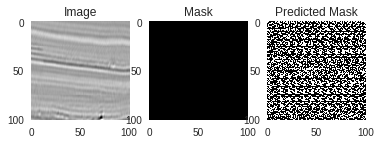

Total Loss is 1.2196403205394746, BCE loss is 0.39365601539611816, IOU loss is 0.6866981387138367, IOU is 0.32500000000000007 at iter 50, Time: 1m 46s


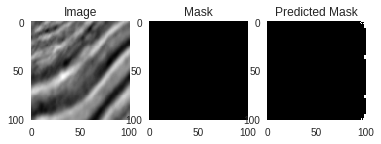

Total Loss is 1.1622264087200165, BCE loss is 0.4355899691581726, IOU loss is 0.7548202276229858, IOU is 0.18333333333333332 at iter 100, Time: 1m 54s


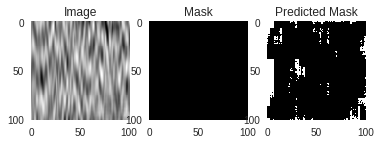

Total Loss is 1.0792783141136169, BCE loss is 0.4006480574607849, IOU loss is 0.8000682592391968, IOU is 0.13333333333333333 at iter 150, Time: 2m 3s


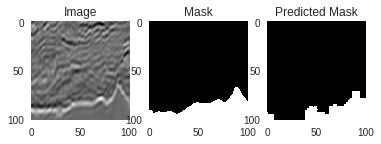

Total Loss is 1.056902039051056, BCE loss is 0.42251667380332947, IOU loss is 0.697104811668396, IOU is 0.31833333333333336 at iter 200, Time: 2m 11s


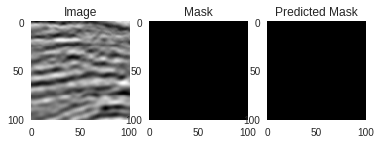

Total Loss is 1.0185128092765807, BCE loss is 0.21629759669303894, IOU loss is 0.7044752240180969, IOU is 0.24333333333333332 at iter 250, Time: 2m 19s


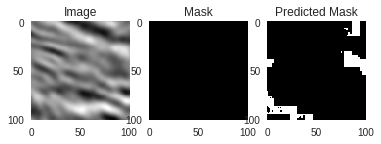

Total Loss is 0.9884681195020676, BCE loss is 0.2694045901298523, IOU loss is 0.6851662397384644, IOU is 0.4066666666666666 at iter 300, Time: 2m 28s


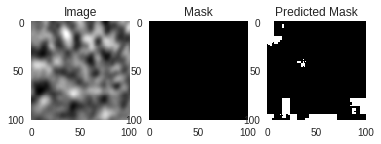

Total Loss is 0.9804284423589706, BCE loss is 0.25918030738830566, IOU loss is 0.6636297702789307, IOU is 0.4033333333333333 at iter 350, Time: 2m 36s


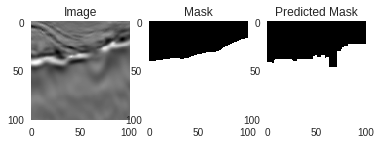

Total Loss is 0.9593926131725311, BCE loss is 0.1975850760936737, IOU loss is 0.6347948312759399, IOU is 0.46166666666666667 at iter 400, Time: 2m 44s


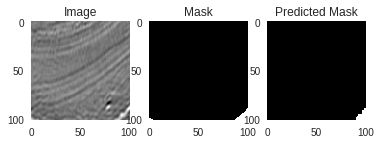

Total Loss is 0.9694489896297455, BCE loss is 0.2657281160354614, IOU loss is 0.6340710520744324, IOU is 0.405 at iter 450, Time: 2m 53s


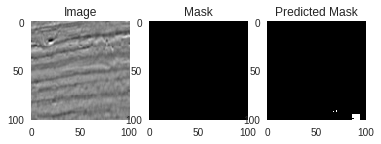

Total Loss is 0.9678051739931106, BCE loss is 0.36434194445610046, IOU loss is 0.6647911667823792, IOU is 0.4016666666666666 at iter 500, Time: 3m 1s


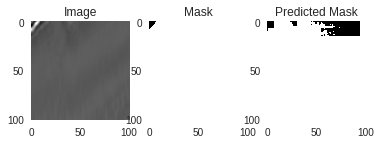

Total Loss is 0.9342364013195038, BCE loss is 0.2138446569442749, IOU loss is 0.6567174196243286, IOU is 0.4483333333333333 at iter 550, Time: 3m 9s


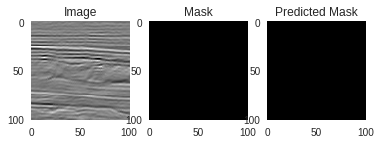

Total Loss is 0.9571588516235352, BCE loss is 0.28534406423568726, IOU loss is 0.6648744344711304, IOU is 0.4316666666666666 at iter 600, Time: 3m 18s


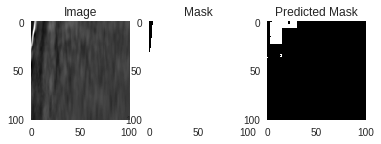

Total Loss is 0.9249813944101334, BCE loss is 0.2829728424549103, IOU loss is 0.6608259677886963, IOU is 0.33166666666666667 at iter 650, Time: 3m 26s


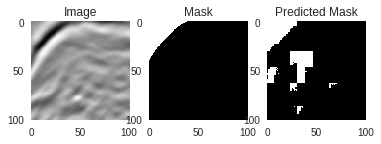

Total Loss is 0.9299379289150238, BCE loss is 0.28851690888404846, IOU loss is 0.6337162256240845, IOU is 0.44000000000000006 at iter 700, Time: 3m 35s


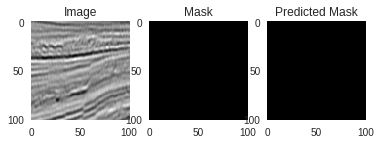

Total Loss is 0.8966156065464019, BCE loss is 0.269791841506958, IOU loss is 0.6409783363342285, IOU is 0.4466666666666666 at iter 750, Time: 3m 43s


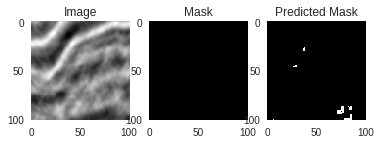

Total Loss is 0.9155045181512833, BCE loss is 0.3090347945690155, IOU loss is 0.7425171136856079, IOU is 0.29500000000000004 at iter 800, Time: 3m 51s


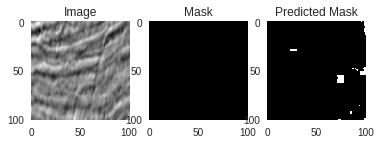

Total Loss is 0.8887051820755005, BCE loss is 0.24567952752113342, IOU loss is 0.6014164686203003, IOU is 0.425 at iter 850, Time: 4m 0s


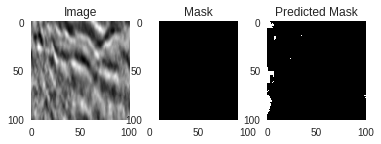

Total Loss is 0.8913396179676056, BCE loss is 0.2140212208032608, IOU loss is 0.6221120357513428, IOU is 0.4216666666666667 at iter 900, Time: 4m 8s


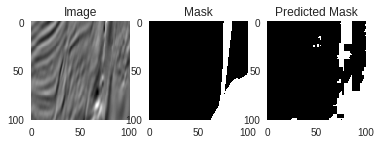

Total Loss is 0.8513474643230439, BCE loss is 0.1874849796295166, IOU loss is 0.6162863969802856, IOU is 0.41833333333333333 at iter 950, Time: 4m 16s


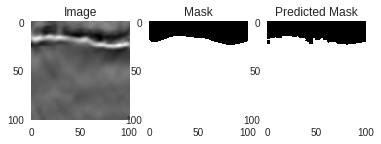

Total Loss is 0.8962762713432312, BCE loss is 0.19467848539352417, IOU loss is 0.6337995529174805, IOU is 0.4033333333333333 at iter 1000, Time: 4m 25s


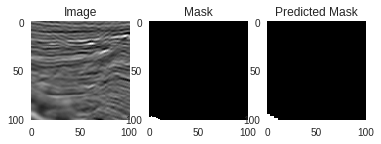

Total Loss is 0.8779798239469528, BCE loss is 0.2043471336364746, IOU loss is 0.6516832113265991, IOU is 0.43 at iter 1050, Time: 4m 33s


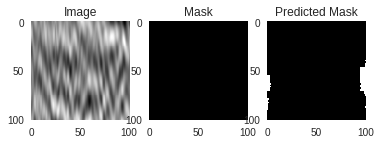

Total Loss is 0.8319948852062226, BCE loss is 0.23146773874759674, IOU loss is 0.5787155628204346, IOU is 0.5483333333333333 at iter 1100, Time: 4m 41s


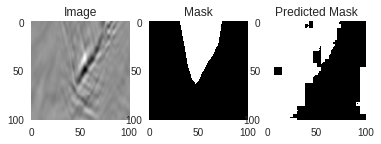

Total Loss is 0.8813880503177642, BCE loss is 0.25368255376815796, IOU loss is 0.5761078596115112, IOU is 0.5683333333333332 at iter 1150, Time: 4m 50s


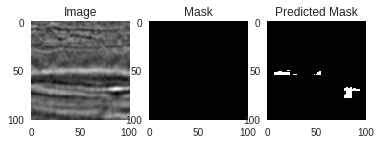

Total Loss is 0.8294073164463043, BCE loss is 0.19940832257270813, IOU loss is 0.5656450986862183, IOU is 0.5033333333333334 at iter 1200, Time: 4m 58s


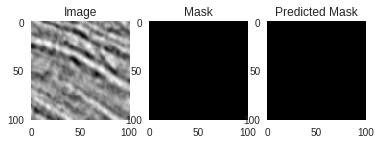

Total Loss is 0.8268003225326538, BCE loss is 0.16513532400131226, IOU loss is 0.5766828060150146, IOU is 0.5116666666666666 at iter 1250, Time: 5m 6s


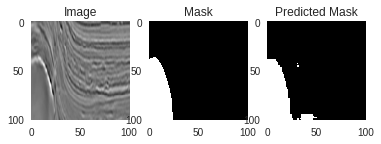

Total Loss is 0.8543006479740143, BCE loss is 0.25214460492134094, IOU loss is 0.6032648086547852, IOU is 0.43166666666666664 at iter 1300, Time: 5m 15s


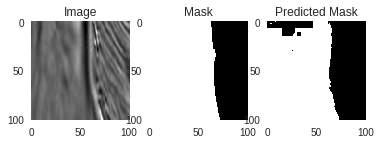

Total Loss is 0.8432718724012375, BCE loss is 0.19565366208553314, IOU loss is 0.6071988344192505, IOU is 0.40166666666666667 at iter 1350, Time: 5m 23s


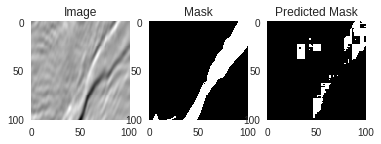

Total Loss is 0.8159482032060623, BCE loss is 0.16906501352787018, IOU loss is 0.5892109870910645, IOU is 0.45833333333333337 at iter 1400, Time: 5m 31s


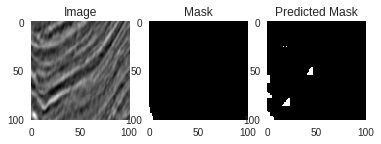

Total Loss is 0.8523051977157593, BCE loss is 0.1992638260126114, IOU loss is 0.6069185733795166, IOU is 0.43666666666666665 at iter 1450, Time: 5m 40s


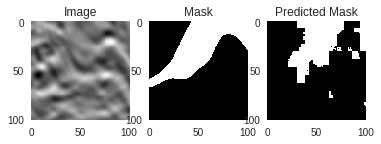

Total Loss is 0.8378723978996276, BCE loss is 0.2744496464729309, IOU loss is 0.6444149017333984, IOU is 0.47333333333333333 at iter 1500, Time: 5m 48s


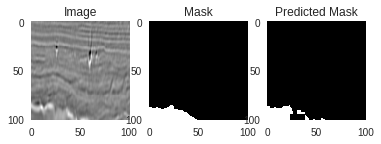

Total Loss is 0.7984020113945007, BCE loss is 0.2357204258441925, IOU loss is 0.6565912961959839, IOU is 0.33999999999999997 at iter 1550, Time: 5m 56s


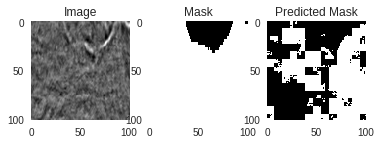

Total Loss is 0.8035616189241409, BCE loss is 0.3049983084201813, IOU loss is 0.5682682394981384, IOU is 0.5466666666666666 at iter 1600, Time: 6m 5s


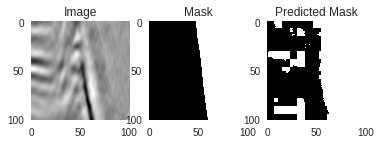

Total Loss is 0.8299647808074951, BCE loss is 0.20996832847595215, IOU loss is 0.5794903635978699, IOU is 0.5033333333333334 at iter 1650, Time: 6m 13s


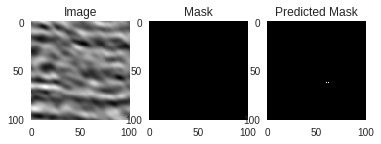

Total Loss is 0.8030933201313019, BCE loss is 0.20647156238555908, IOU loss is 0.5440068244934082, IOU is 0.4983333333333333 at iter 1700, Time: 6m 22s


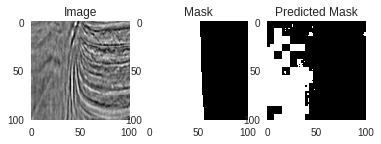

Total Loss is 0.7905740320682526, BCE loss is 0.19965499639511108, IOU loss is 0.5716873407363892, IOU is 0.505 at iter 1750, Time: 6m 30s


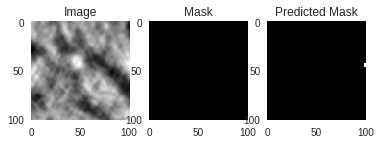

Total Loss is 0.8177990823984146, BCE loss is 0.2560814619064331, IOU loss is 0.6417313814163208, IOU is 0.4 at iter 1800, Time: 6m 38s


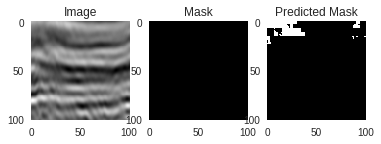

Total Loss is 0.7751280277967453, BCE loss is 0.15939024090766907, IOU loss is 0.5339298248291016, IOU is 0.4933333333333333 at iter 1850, Time: 6m 47s


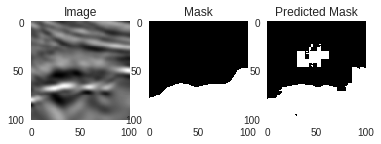

Total Loss is 0.7593750774860382, BCE loss is 0.1679604947566986, IOU loss is 0.5558884143829346, IOU is 0.5583333333333333 at iter 1900, Time: 6m 55s


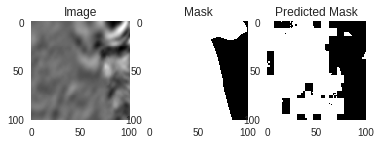

Total Loss is 0.8026453375816345, BCE loss is 0.24569982290267944, IOU loss is 0.5821198225021362, IOU is 0.4033333333333334 at iter 1950, Time: 7m 3s


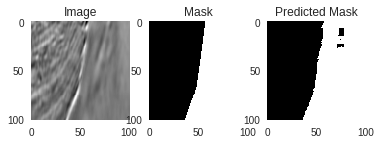

Total Loss is 0.7885717004537582, BCE loss is 0.2716853618621826, IOU loss is 0.6144459247589111, IOU is 0.38166666666666665 at iter 2000, Time: 7m 12s


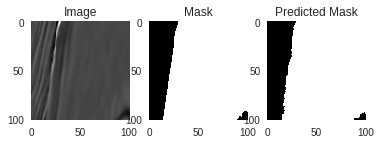

Total Loss is 0.7657146126031875, BCE loss is 0.14916571974754333, IOU loss is 0.5612255334854126, IOU is 0.5533333333333332 at iter 2050, Time: 7m 20s


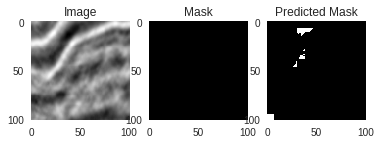

Total Loss is 0.7814353436231614, BCE loss is 0.26700451970100403, IOU loss is 0.5668481588363647, IOU is 0.5433333333333333 at iter 2100, Time: 7m 28s


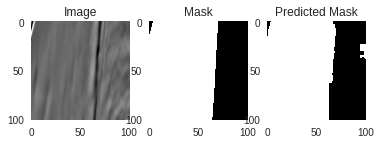

Total Loss is 0.7802302837371826, BCE loss is 0.19376303255558014, IOU loss is 0.5514750480651855, IOU is 0.5 at iter 2150, Time: 7m 37s


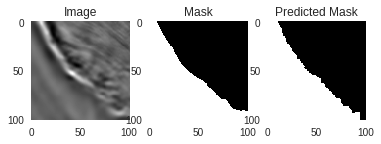

Total Loss is 0.7729248762130737, BCE loss is 0.1901714950799942, IOU loss is 0.5929617881774902, IOU is 0.43333333333333335 at iter 2200, Time: 7m 45s


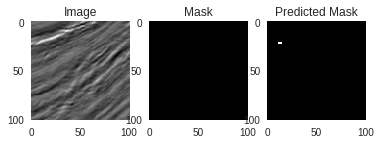

Total Loss is 0.7634674817323684, BCE loss is 0.20288603007793427, IOU loss is 0.5776165723800659, IOU is 0.38000000000000006 at iter 2250, Time: 7m 53s


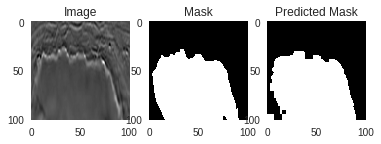

Total Loss is 0.7607278138399124, BCE loss is 0.16655512154102325, IOU loss is 0.6583684682846069, IOU is 0.38 at iter 2300, Time: 8m 2s


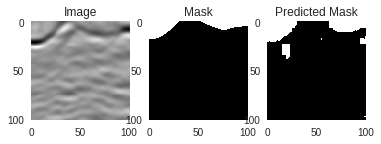

Total Loss is 0.7521608233451843, BCE loss is 0.19406606256961823, IOU loss is 0.5475066304206848, IOU is 0.525 at iter 2350, Time: 8m 10s


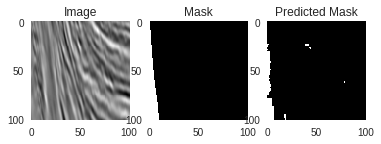

Total Loss is 0.7654807686805725, BCE loss is 0.17697526514530182, IOU loss is 0.6137458086013794, IOU is 0.4166666666666667 at iter 2400, Time: 8m 18s


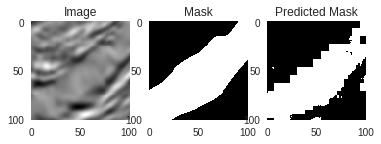

Total Loss is 0.7352146238088608, BCE loss is 0.13495448231697083, IOU loss is 0.5806901454925537, IOU is 0.41000000000000003 at iter 2450, Time: 8m 27s


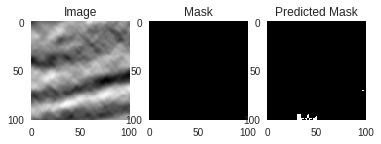

Total Loss is 0.7475770831108093, BCE loss is 0.13853174448013306, IOU loss is 0.5486979484558105, IOU is 0.5083333333333333 at iter 2500, Time: 8m 35s


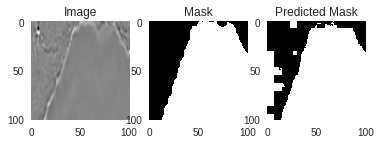

Total Loss is 0.7707689702510834, BCE loss is 0.16181638836860657, IOU loss is 0.6392456293106079, IOU is 0.3949999999999999 at iter 2550, Time: 8m 43s


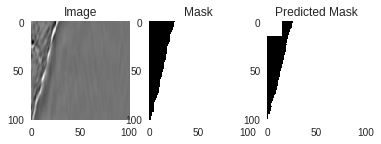

Total Loss is 0.7729256540536881, BCE loss is 0.2715538442134857, IOU loss is 0.6194157004356384, IOU is 0.4533333333333333 at iter 2600, Time: 8m 52s


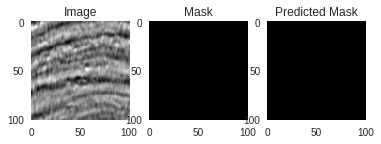

Total Loss is 0.7345780283212662, BCE loss is 0.14142239093780518, IOU loss is 0.5444557666778564, IOU is 0.525 at iter 2650, Time: 9m 0s


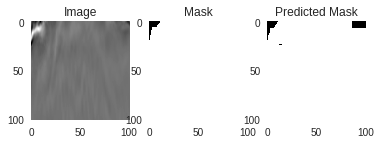

Total Loss is 0.752720320224762, BCE loss is 0.1362595111131668, IOU loss is 0.5597996711730957, IOU is 0.51 at iter 2700, Time: 9m 9s


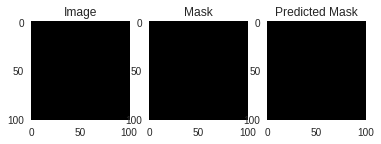

Total Loss is 0.721879842877388, BCE loss is 0.11492906510829926, IOU loss is 0.5135631561279297, IOU is 0.5133333333333333 at iter 2750, Time: 9m 17s


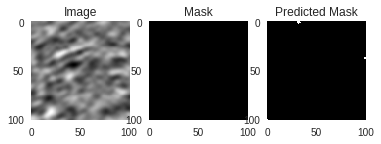

Total Loss is 0.7454097539186477, BCE loss is 0.213039368391037, IOU loss is 0.5582260489463806, IOU is 0.4233333333333333 at iter 2800, Time: 9m 25s


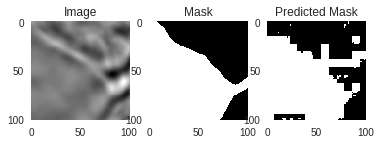

Total Loss is 0.7378030717372894, BCE loss is 0.26774969696998596, IOU loss is 0.6214315891265869, IOU is 0.4183333333333333 at iter 2850, Time: 9m 34s


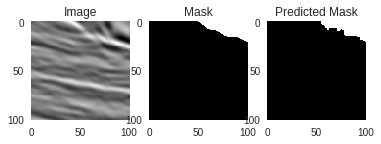

Total Loss is 0.722387969493866, BCE loss is 0.1709749698638916, IOU loss is 0.5077915191650391, IOU is 0.5416666666666666 at iter 2900, Time: 9m 42s


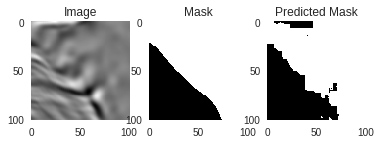

Total Loss is 0.7019432812929154, BCE loss is 0.11088566482067108, IOU loss is 0.5272536277770996, IOU is 0.53 at iter 2950, Time: 9m 50s


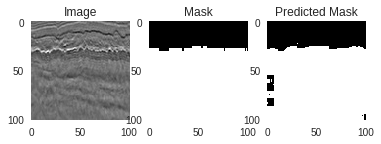

Total Loss is 0.7124772429466247, BCE loss is 0.11871681362390518, IOU loss is 0.5187397003173828, IOU is 0.5966666666666666 at iter 3000, Time: 9m 59s


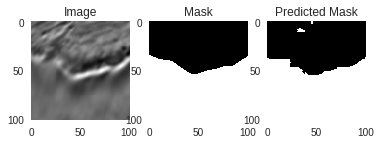

Total Loss is 0.7244286298751831, BCE loss is 0.1369834840297699, IOU loss is 0.46392709016799927, IOU is 0.6216666666666666 at iter 3050, Time: 10m 7s


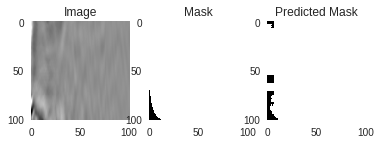

Total Loss is 0.6707157880067826, BCE loss is 0.14617982506752014, IOU loss is 0.5085728168487549, IOU is 0.4850000000000001 at iter 3100, Time: 10m 15s


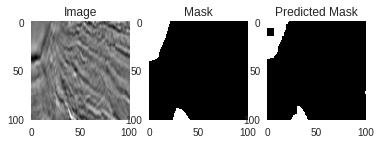

Total Loss is 0.6935789555311203, BCE loss is 0.15500137209892273, IOU loss is 0.5882538557052612, IOU is 0.5566666666666666 at iter 3150, Time: 10m 24s


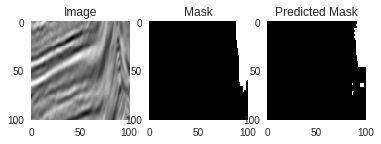

Total Loss is 0.6585216671228409, BCE loss is 0.13500599563121796, IOU loss is 0.588603138923645, IOU is 0.495 at iter 3200, Time: 10m 32s


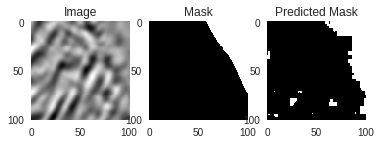

Total Loss is 0.7546424299478531, BCE loss is 0.09470096230506897, IOU loss is 0.516569972038269, IOU is 0.51 at iter 3250, Time: 10m 40s


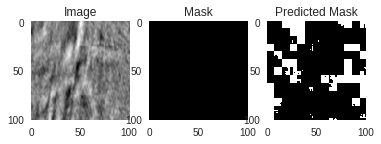

Total Loss is 0.7054981112480163, BCE loss is 0.15434221923351288, IOU loss is 0.5006793737411499, IOU is 0.535 at iter 3300, Time: 10m 49s


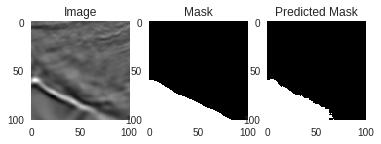

Total Loss is 0.6766952514648438, BCE loss is 0.10694926232099533, IOU loss is 0.5372812747955322, IOU is 0.4583333333333333 at iter 3350, Time: 10m 57s


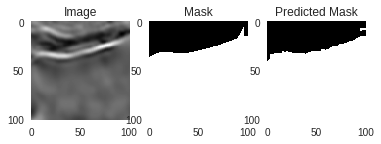

Total Loss is 0.6866494208574295, BCE loss is 0.18385715782642365, IOU loss is 0.6451939344406128, IOU is 0.3516666666666666 at iter 3400, Time: 11m 6s


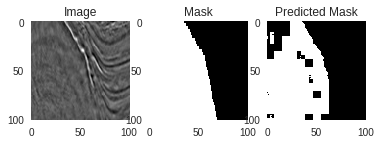

Total Loss is 0.6666797727346421, BCE loss is 0.1198178306221962, IOU loss is 0.4420734643936157, IOU is 0.5483333333333333 at iter 3450, Time: 11m 14s


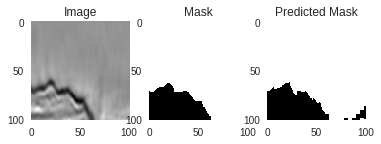

Total Loss is 0.6636314570903779, BCE loss is 0.11567717045545578, IOU loss is 0.4439964294433594, IOU is 0.5499999999999999 at iter 3500, Time: 11m 22s


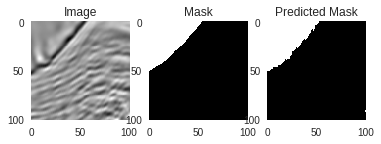

Total Loss is 0.6540841341018677, BCE loss is 0.19096770882606506, IOU loss is 0.45704978704452515, IOU is 0.5333333333333333 at iter 3550, Time: 11m 31s


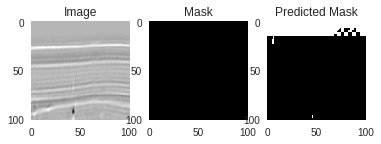

Total Loss is 0.6530981123447418, BCE loss is 0.18862241506576538, IOU loss is 0.4690919518470764, IOU is 0.6033333333333333 at iter 3600, Time: 11m 39s


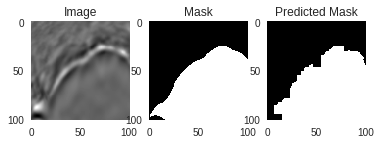

Total Loss is 0.6967922359704971, BCE loss is 0.19126716256141663, IOU loss is 0.6175920367240906, IOU is 0.4216666666666667 at iter 3650, Time: 11m 47s


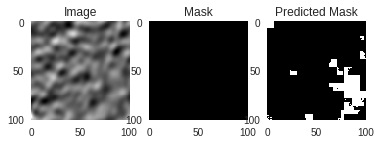

Total Loss is 0.6606278359889984, BCE loss is 0.14299796521663666, IOU loss is 0.5787069797515869, IOU is 0.46 at iter 3700, Time: 11m 56s


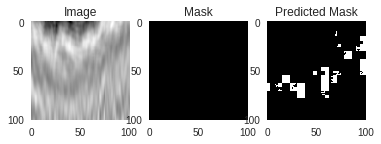

Total Loss is 0.6634247362613678, BCE loss is 0.19240987300872803, IOU loss is 0.5227378010749817, IOU is 0.5016666666666667 at iter 3750, Time: 12m 4s


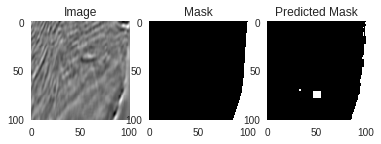

Total Loss is 0.654085972905159, BCE loss is 0.08269105851650238, IOU loss is 0.4680866003036499, IOU is 0.5583333333333333 at iter 3800, Time: 12m 12s


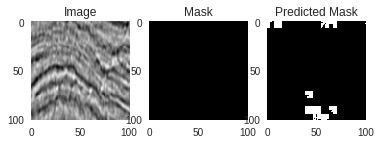

Total Loss is 0.6682578667998313, BCE loss is 0.16004729270935059, IOU loss is 0.5824569463729858, IOU is 0.44333333333333336 at iter 3850, Time: 12m 21s


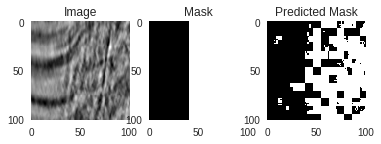

Total Loss is 0.6957502156496048, BCE loss is 0.13724114000797272, IOU loss is 0.5391676425933838, IOU is 0.455 at iter 3900, Time: 12m 29s


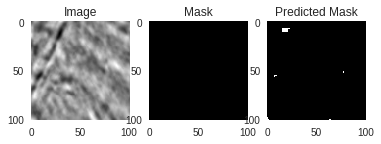

Total Loss is 0.6546484082937241, BCE loss is 0.18526987731456757, IOU loss is 0.5383089184761047, IOU is 0.5066666666666667 at iter 3950, Time: 12m 37s


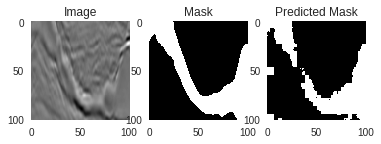

Total Loss is 0.644482335448265, BCE loss is 0.13246719539165497, IOU loss is 0.521957516670227, IOU is 0.5566666666666666 at iter 4000, Time: 12m 46s


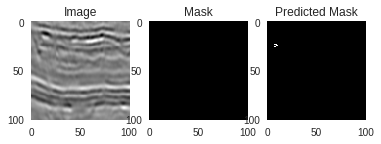

Total Loss is 0.6365276604890824, BCE loss is 0.13463397324085236, IOU loss is 0.5610370635986328, IOU is 0.4716666666666666 at iter 4050, Time: 12m 54s


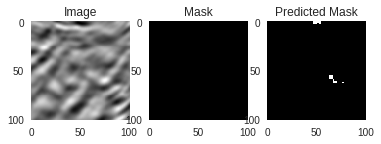

Total Loss is 0.6414275169372559, BCE loss is 0.08644558489322662, IOU loss is 0.5238254070281982, IOU is 0.525 at iter 4100, Time: 13m 3s


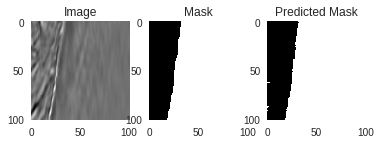

Total Loss is 0.6835107326507568, BCE loss is 0.1968666911125183, IOU loss is 0.5049777626991272, IOU is 0.515 at iter 4150, Time: 13m 11s


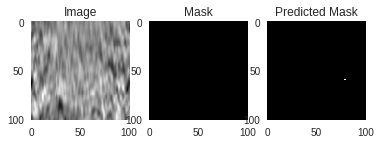

Total Loss is 0.6433317571878433, BCE loss is 0.09292904287576675, IOU loss is 0.5079579949378967, IOU is 0.6183333333333333 at iter 4200, Time: 13m 19s


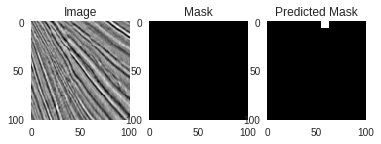

Total Loss is 0.6283974200487137, BCE loss is 0.12884478271007538, IOU loss is 0.6158586740493774, IOU is 0.39166666666666666 at iter 4250, Time: 13m 28s


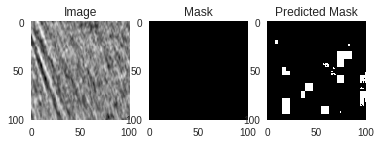

Total Loss is 0.6334058910608291, BCE loss is 0.18931826949119568, IOU loss is 0.4659166932106018, IOU is 0.6566666666666666 at iter 4300, Time: 13m 36s


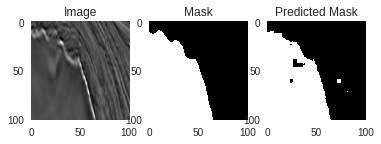

Total Loss is 0.6287274658679962, BCE loss is 0.09347934275865555, IOU loss is 0.48253244161605835, IOU is 0.5683333333333334 at iter 4350, Time: 13m 45s


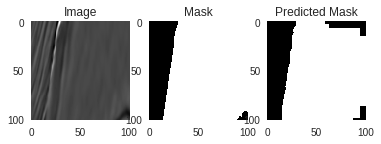

Total Loss is 0.6736432015895844, BCE loss is 0.20783068239688873, IOU loss is 0.4710742235183716, IOU is 0.61 at iter 4400, Time: 13m 53s


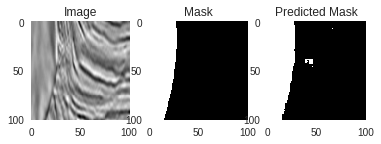

Total Loss is 0.6208198249340058, BCE loss is 0.10172299295663834, IOU loss is 0.5804218053817749, IOU is 0.48833333333333334 at iter 4450, Time: 14m 1s


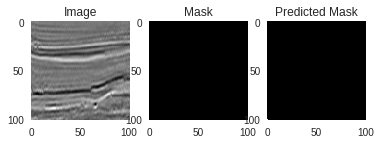

Total Loss is 0.6388676255941391, BCE loss is 0.10514049977064133, IOU loss is 0.5494613647460938, IOU is 0.575 at iter 4500, Time: 14m 10s


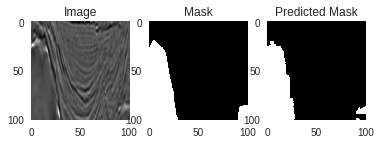

Total Loss is 0.6169172108173371, BCE loss is 0.07529148459434509, IOU loss is 0.45333343744277954, IOU is 0.6300000000000001 at iter 4550, Time: 14m 18s


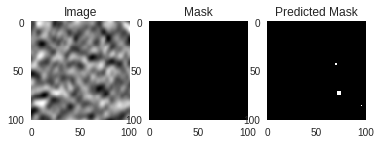

Total Loss is 0.6142025798559189, BCE loss is 0.08585343509912491, IOU loss is 0.5492515563964844, IOU is 0.5466666666666667 at iter 4600, Time: 14m 26s


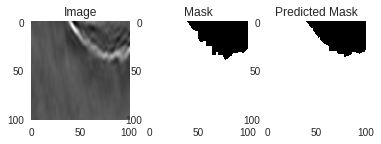

Total Loss is 0.6499912068247795, BCE loss is 0.1251617819070816, IOU loss is 0.6558539867401123, IOU is 0.47333333333333333 at iter 4650, Time: 14m 35s


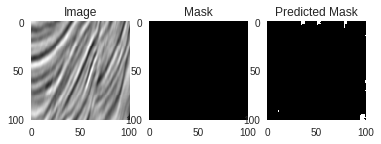

Total Loss is 0.6380317255854606, BCE loss is 0.08490168303251266, IOU loss is 0.44781190156936646, IOU is 0.5833333333333333 at iter 4700, Time: 14m 43s


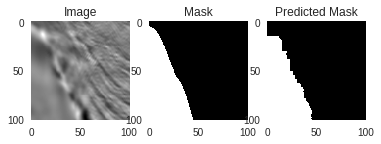

Total Loss is 0.6208444118499756, BCE loss is 0.10671985894441605, IOU loss is 0.5434491634368896, IOU is 0.5849999999999999 at iter 4750, Time: 14m 51s


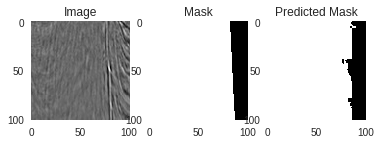

Total Loss is 0.58953547924757, BCE loss is 0.11784810572862625, IOU loss is 0.5251264572143555, IOU is 0.5283333333333334 at iter 4800, Time: 15m 0s


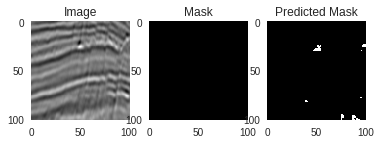

Total Loss is 0.6265617728233337, BCE loss is 0.11175739765167236, IOU loss is 0.4153834581375122, IOU is 0.6166666666666668 at iter 4850, Time: 15m 8s


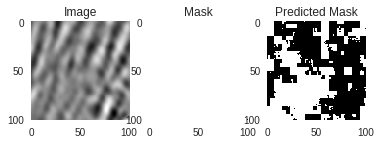

Total Loss is 0.593911299109459, BCE loss is 0.20798183977603912, IOU loss is 0.45381951332092285, IOU is 0.6316666666666667 at iter 4900, Time: 15m 16s


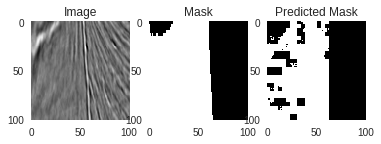

Total Loss is 0.6392133176326752, BCE loss is 0.13562388718128204, IOU loss is 0.49582886695861816, IOU is 0.5849999999999999 at iter 4950, Time: 15m 25s


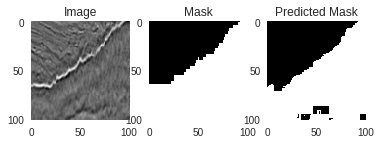

Total Loss is 0.5864105835556984, BCE loss is 0.12761057913303375, IOU loss is 0.5631119608879089, IOU is 0.5983333333333333 at iter 5000, Time: 15m 33s


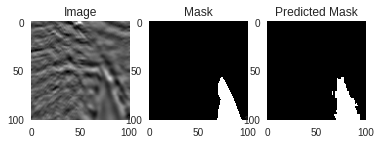

Total Loss is 0.5894174605607987, BCE loss is 0.08739959448575974, IOU loss is 0.5672250986099243, IOU is 0.435 at iter 5050, Time: 15m 41s


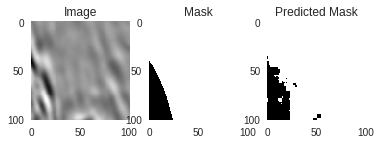

Total Loss is 0.6381968706846237, BCE loss is 0.13804112374782562, IOU loss is 0.44906550645828247, IOU is 0.6366666666666666 at iter 5100, Time: 15m 50s


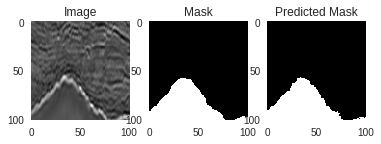

Total Loss is 0.5761045157909394, BCE loss is 0.07413381338119507, IOU loss is 0.47461116313934326, IOU is 0.5966666666666668 at iter 5150, Time: 15m 58s


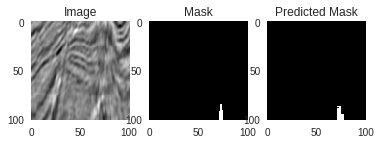

Total Loss is 0.6239593684673309, BCE loss is 0.11126094311475754, IOU loss is 0.5235306024551392, IOU is 0.6383333333333334 at iter 5200, Time: 16m 7s


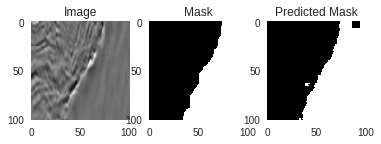

Total Loss is 0.5922648295760155, BCE loss is 0.10202621668577194, IOU loss is 0.42776161432266235, IOU is 0.6433333333333333 at iter 5250, Time: 16m 15s


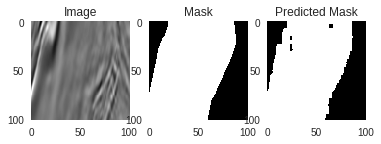

Total Loss is 0.621883773803711, BCE loss is 0.11878652125597, IOU loss is 0.47867488861083984, IOU is 0.6599999999999999 at iter 5300, Time: 16m 23s


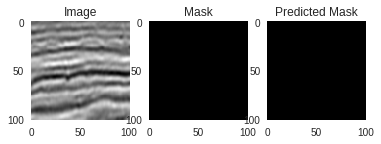

Total Loss is 0.6248229593038559, BCE loss is 0.10716123878955841, IOU loss is 0.5039677619934082, IOU is 0.5033333333333333 at iter 5350, Time: 16m 32s


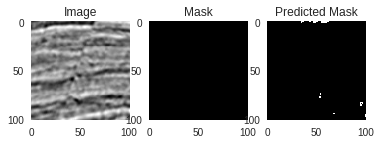

Total Loss is 0.5844862580299377, BCE loss is 0.08301423490047455, IOU loss is 0.5754512548446655, IOU is 0.535 at iter 5400, Time: 16m 40s


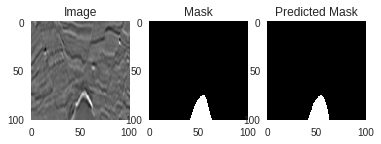

Total Loss is 0.5831797048449516, BCE loss is 0.13152992725372314, IOU loss is 0.6349660158157349, IOU is 0.345 at iter 5450, Time: 16m 48s


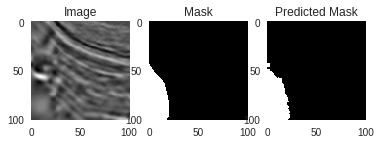

Total Loss is 0.565392816066742, BCE loss is 0.08043570071458817, IOU loss is 0.4862592816352844, IOU is 0.5750000000000001 at iter 5500, Time: 16m 57s


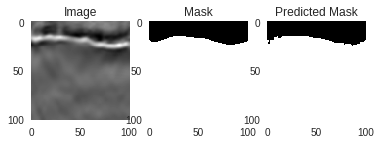

Total Loss is 0.547675396502018, BCE loss is 0.07777239382266998, IOU loss is 0.49809181690216064, IOU is 0.5400000000000001 at iter 5550, Time: 17m 5s


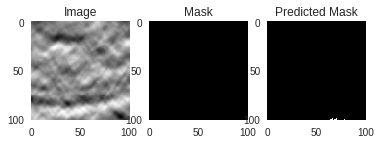

Total Loss is 0.5802767604589463, BCE loss is 0.1715162992477417, IOU loss is 0.47462886571884155, IOU is 0.6116666666666667 at iter 5600, Time: 17m 13s


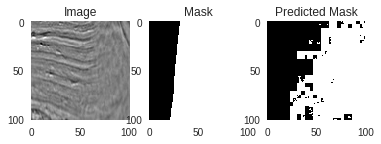

Total Loss is 0.5846365243196487, BCE loss is 0.1389646977186203, IOU loss is 0.48031800985336304, IOU is 0.6333333333333332 at iter 5650, Time: 17m 22s


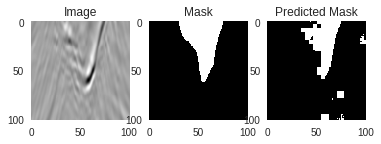

Total Loss is 0.5542517960071563, BCE loss is 0.07451231777667999, IOU loss is 0.48724573850631714, IOU is 0.5700000000000001 at iter 5700, Time: 17m 30s


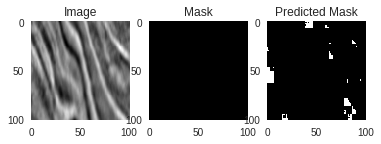

Total Loss is 0.5787624418735504, BCE loss is 0.07632683217525482, IOU loss is 0.408092737197876, IOU is 0.6516666666666667 at iter 5750, Time: 17m 38s


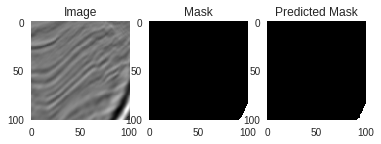

Total Loss is 0.5776156932115555, BCE loss is 0.0665782168507576, IOU loss is 0.49230629205703735, IOU is 0.5399999999999999 at iter 5800, Time: 17m 47s


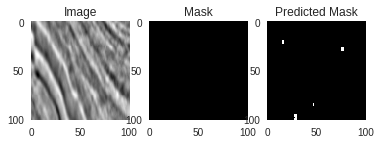

Total Loss is 0.6089201658964157, BCE loss is 0.0897088423371315, IOU loss is 0.5087749361991882, IOU is 0.5333333333333333 at iter 5850, Time: 17m 55s


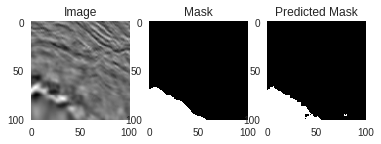

Total Loss is 0.5774140402674675, BCE loss is 0.0766342356801033, IOU loss is 0.4672618508338928, IOU is 0.6649999999999999 at iter 5900, Time: 18m 3s


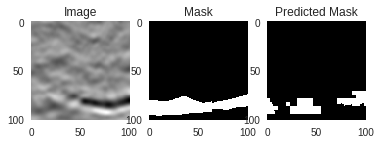

Total Loss is 0.6253462865948677, BCE loss is 0.08987835049629211, IOU loss is 0.3415895104408264, IOU is 0.7166666666666667 at iter 5950, Time: 18m 12s


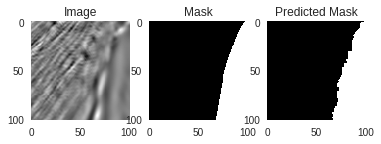

Total Loss is 0.5755363434553147, BCE loss is 0.043366171419620514, IOU loss is 0.5619667768478394, IOU is 0.5399999999999999 at iter 6000, Time: 18m 20s


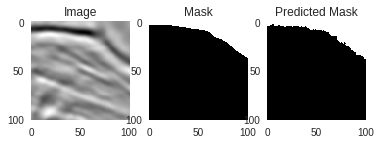

Total Loss is 0.573269858956337, BCE loss is 0.05350690335035324, IOU loss is 0.47166967391967773, IOU is 0.575 at iter 6050, Time: 18m 28s


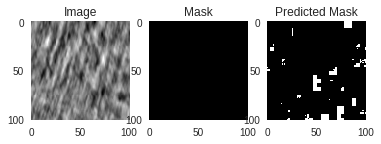

Total Loss is 0.5639879196882248, BCE loss is 0.04931110516190529, IOU loss is 0.4281323552131653, IOU is 0.6199999999999999 at iter 6100, Time: 18m 37s


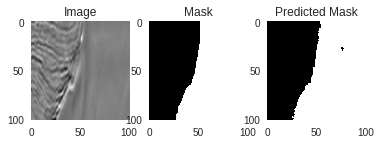

Total Loss is 0.5532506123185158, BCE loss is 0.07064484059810638, IOU loss is 0.3855903148651123, IOU is 0.73 at iter 6150, Time: 18m 45s


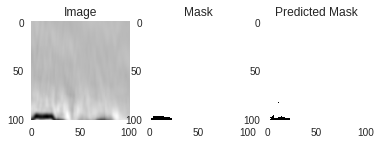

Total Loss is 0.5888634070754051, BCE loss is 0.10984762012958527, IOU loss is 0.5778225660324097, IOU is 0.4683333333333333 at iter 6200, Time: 18m 54s


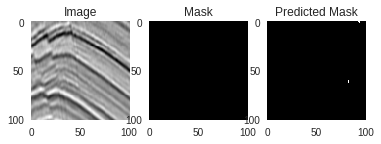

Total Loss is 0.5530800938606262, BCE loss is 0.04367661103606224, IOU loss is 0.4102436900138855, IOU is 0.725 at iter 6250, Time: 19m 2s


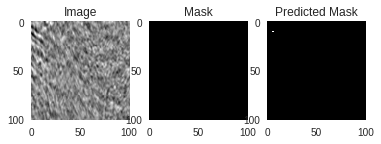

Total Loss is 0.5592343598604202, BCE loss is 0.07194681465625763, IOU loss is 0.4243100881576538, IOU is 0.6799999999999999 at iter 6300, Time: 19m 10s


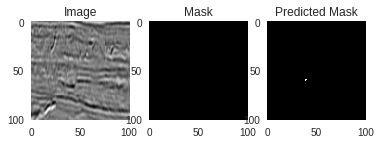

Total Loss is 0.5340875804424285, BCE loss is 0.060132451355457306, IOU loss is 0.4296862483024597, IOU is 0.6116666666666666 at iter 6350, Time: 19m 19s


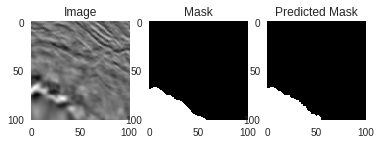

Total Loss is 0.5486245468258858, BCE loss is 0.06439889967441559, IOU loss is 0.5344064235687256, IOU is 0.62 at iter 6400, Time: 19m 27s


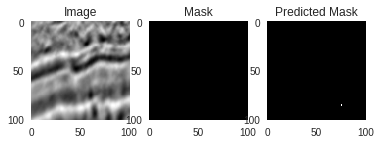

Total Loss is 0.5411206662654877, BCE loss is 0.06659601628780365, IOU loss is 0.4820520877838135, IOU is 0.5766666666666667 at iter 6450, Time: 19m 35s


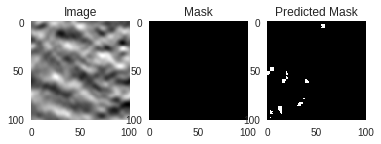

Total Loss is 0.5389659687876701, BCE loss is 0.15464967489242554, IOU loss is 0.4714457392692566, IOU is 0.5549999999999999 at iter 6500, Time: 19m 44s


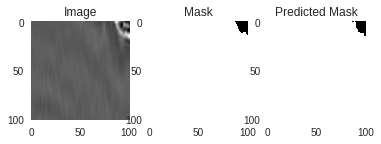

Total Loss is 0.5617429867386818, BCE loss is 0.04143361374735832, IOU loss is 0.5031530857086182, IOU is 0.6899999999999998 at iter 6550, Time: 19m 52s


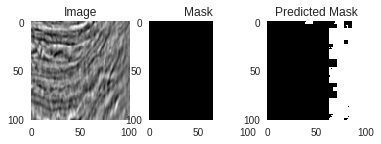

Total Loss is 0.5867269799113274, BCE loss is 0.080777108669281, IOU loss is 0.45062804222106934, IOU is 0.6766666666666669 at iter 6600, Time: 20m 0s


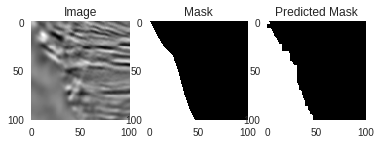

Total Loss is 0.5418136492371559, BCE loss is 0.05717714503407478, IOU loss is 0.47719907760620117, IOU is 0.6766666666666666 at iter 6650, Time: 20m 9s


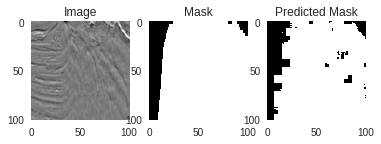

Total Loss is 0.5445216864347457, BCE loss is 0.09742256253957748, IOU loss is 0.449593186378479, IOU is 0.6416666666666665 at iter 6700, Time: 20m 17s


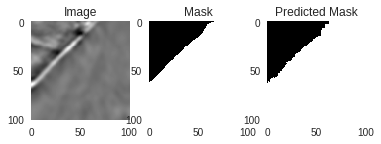

Total Loss is 0.5414428099989891, BCE loss is 0.080782450735569, IOU loss is 0.3929913640022278, IOU is 0.73 at iter 6750, Time: 20m 25s


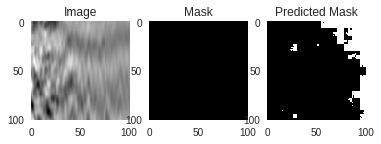

Total Loss is 0.5670674771070481, BCE loss is 0.05312339961528778, IOU loss is 0.45380908250808716, IOU is 0.6666666666666666 at iter 6800, Time: 20m 34s


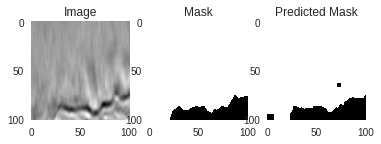

Total Loss is 0.5540207788348198, BCE loss is 0.07200067490339279, IOU loss is 0.4366803765296936, IOU is 0.6083333333333333 at iter 6850, Time: 20m 42s


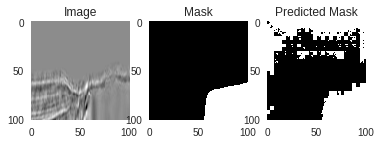

Total Loss is 0.5261934161186218, BCE loss is 0.0756516382098198, IOU loss is 0.46031689643859863, IOU is 0.575 at iter 6900, Time: 20m 51s


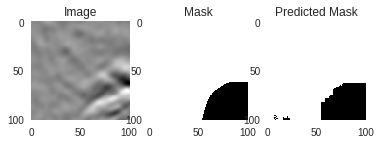

Total Loss is 0.5373262032866478, BCE loss is 0.09893938899040222, IOU loss is 0.4665899872779846, IOU is 0.6433333333333333 at iter 6950, Time: 20m 59s


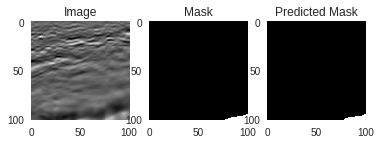

Total Loss is 0.5541421219706535, BCE loss is 0.05856567621231079, IOU loss is 0.44763606786727905, IOU is 0.6599999999999999 at iter 7000, Time: 21m 7s


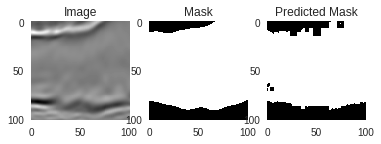

Total Loss is 0.5298139467835427, BCE loss is 0.12848691642284393, IOU loss is 0.5035833716392517, IOU is 0.64 at iter 7050, Time: 21m 16s


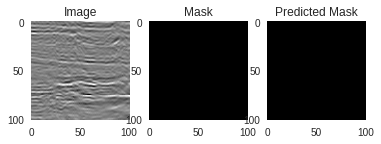

Total Loss is 0.5427441239356995, BCE loss is 0.07376811653375626, IOU loss is 0.3799054026603699, IOU is 0.7300000000000001 at iter 7100, Time: 21m 24s


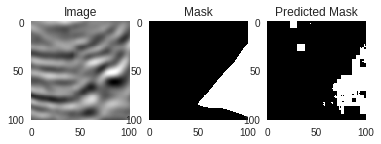

Total Loss is 0.5481289029121399, BCE loss is 0.04803946614265442, IOU loss is 0.46433836221694946, IOU is 0.5666666666666667 at iter 7150, Time: 21m 32s


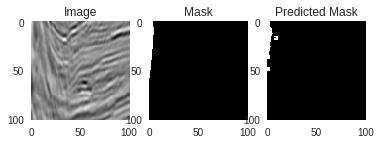

Total Loss is 0.5414066404104233, BCE loss is 0.1706419438123703, IOU loss is 0.46688228845596313, IOU is 0.6983333333333334 at iter 7200, Time: 21m 41s


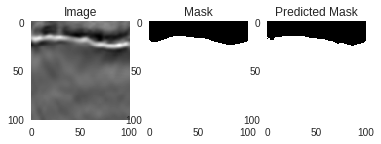

Total Loss is 0.5616507425904274, BCE loss is 0.1659965068101883, IOU loss is 0.40696775913238525, IOU is 0.625 at iter 7250, Time: 21m 49s


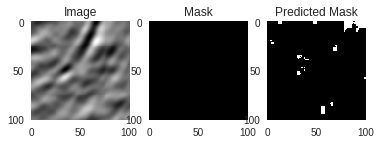

Total Loss is 0.5402581200003624, BCE loss is 0.12952809035778046, IOU loss is 0.4599713087081909, IOU is 0.7099999999999999 at iter 7300, Time: 21m 57s


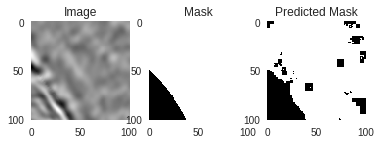

Total Loss is 0.5362204626202584, BCE loss is 0.058226969093084335, IOU loss is 0.43854302167892456, IOU is 0.62 at iter 7350, Time: 22m 6s


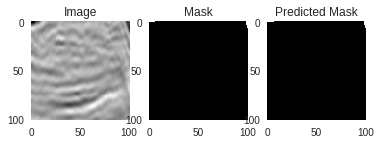

Total Loss is 0.5207490772008896, BCE loss is 0.05615800619125366, IOU loss is 0.4559119939804077, IOU is 0.6883333333333332 at iter 7400, Time: 22m 14s


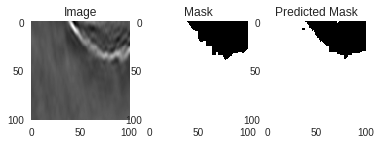

Total Loss is 0.5239059939980507, BCE loss is 0.08002852648496628, IOU loss is 0.5459537506103516, IOU is 0.5783333333333334 at iter 7450, Time: 22m 22s


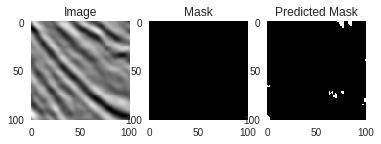

Total Loss is 0.5457960516214371, BCE loss is 0.12250979244709015, IOU loss is 0.6213679313659668, IOU is 0.43166666666666664 at iter 7500, Time: 22m 31s


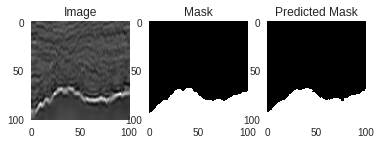

Total Loss is 0.5559693872928619, BCE loss is 0.03917156904935837, IOU loss is 0.3835524320602417, IOU is 0.745 at iter 7550, Time: 22m 39s


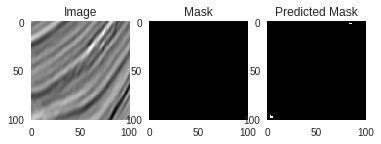

Total Loss is 0.5599990367889405, BCE loss is 0.14181795716285706, IOU loss is 0.5590965747833252, IOU is 0.5283333333333332 at iter 7600, Time: 22m 47s


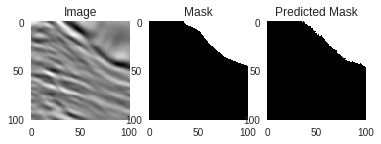

Total Loss is 0.5519871816039086, BCE loss is 0.05540445074439049, IOU loss is 0.4391863942146301, IOU is 0.6783333333333332 at iter 7650, Time: 22m 56s


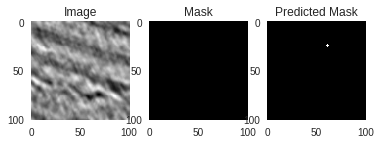

Total Loss is 0.5526049733161926, BCE loss is 0.15252260863780975, IOU loss is 0.6666030883789062, IOU is 0.4233333333333333 at iter 7700, Time: 23m 4s


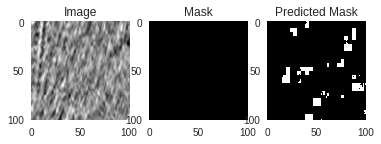

Total Loss is 0.5284215182065963, BCE loss is 0.07019706070423126, IOU loss is 0.39838725328445435, IOU is 0.7433333333333333 at iter 7750, Time: 23m 13s


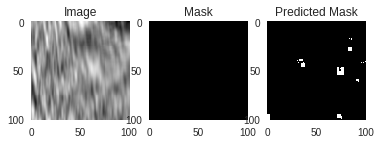

Total Loss is 0.5699698820710182, BCE loss is 0.05375918000936508, IOU loss is 0.5584408044815063, IOU is 0.5283333333333333 at iter 7800, Time: 23m 21s


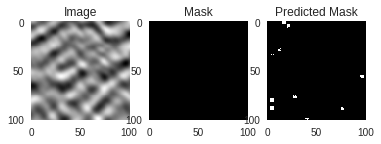

Total Loss is 0.5873083025217056, BCE loss is 0.11970604211091995, IOU loss is 0.46085572242736816, IOU is 0.6083333333333332 at iter 7850, Time: 23m 29s


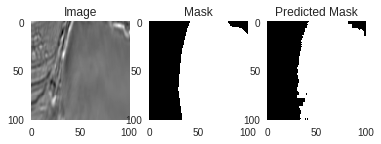

Total Loss is 0.535342837870121, BCE loss is 0.08736176788806915, IOU loss is 0.41617923974990845, IOU is 0.6383333333333334 at iter 7900, Time: 23m 38s


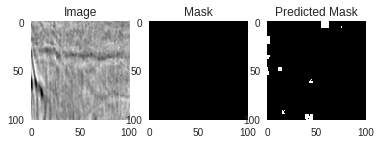

Total Loss is 0.5284467279911041, BCE loss is 0.08642234653234482, IOU loss is 0.42076319456100464, IOU is 0.7483333333333333 at iter 7950, Time: 23m 46s


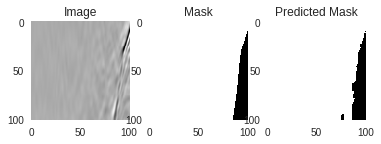

Total Loss is 0.5005884826183319, BCE loss is 0.03854015842080116, IOU loss is 0.3861251473426819, IOU is 0.7216666666666668 at iter 8000, Time: 23m 54s


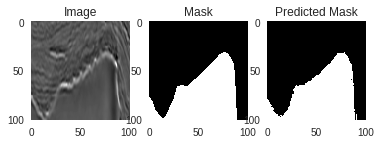

Total Loss is 0.5445751041173935, BCE loss is 0.0670245885848999, IOU loss is 0.5125388503074646, IOU is 0.6433333333333333 at iter 8050, Time: 24m 3s


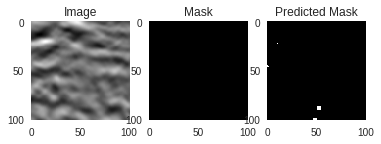

Total Loss is 0.5790029317140579, BCE loss is 0.08613672852516174, IOU loss is 0.43024706840515137, IOU is 0.6899999999999998 at iter 8100, Time: 24m 11s


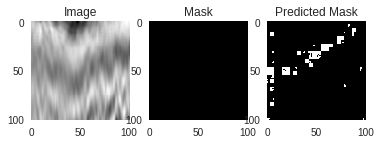

Total Loss is 0.5185628369450569, BCE loss is 0.0366145484149456, IOU loss is 0.4142821431159973, IOU is 0.7316666666666668 at iter 8150, Time: 24m 19s


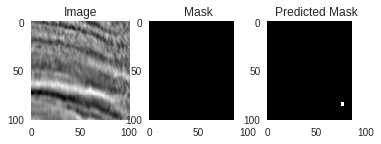

Total Loss is 0.551795843243599, BCE loss is 0.06273943185806274, IOU loss is 0.43895775079727173, IOU is 0.7516666666666667 at iter 8200, Time: 24m 28s


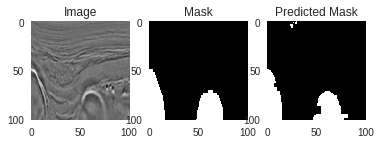

Total Loss is 0.5094299837946892, BCE loss is 0.05114351212978363, IOU loss is 0.4347759485244751, IOU is 0.66 at iter 8250, Time: 24m 36s


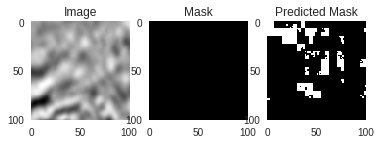

Total Loss is 0.5469315335154533, BCE loss is 0.13553138077259064, IOU loss is 0.4680032730102539, IOU is 0.6333333333333333 at iter 8300, Time: 24m 45s


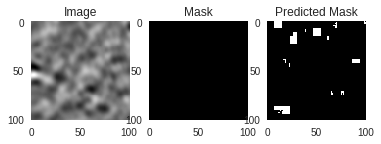

Total Loss is 0.504533340036869, BCE loss is 0.058019496500492096, IOU loss is 0.5114573836326599, IOU is 0.6166666666666667 at iter 8350, Time: 24m 53s


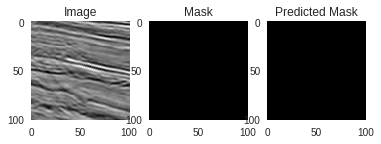

Total Loss is 0.529951174557209, BCE loss is 0.0773950070142746, IOU loss is 0.5998358726501465, IOU is 0.44 at iter 8400, Time: 25m 1s


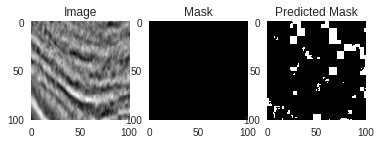

Total Loss is 0.5181298524141311, BCE loss is 0.04647814482450485, IOU loss is 0.547767698764801, IOU is 0.5166666666666667 at iter 8450, Time: 25m 10s


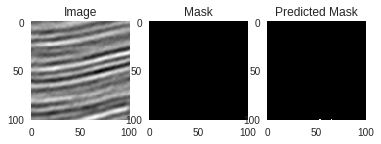

Total Loss is 0.5228871703147888, BCE loss is 0.05517420917749405, IOU loss is 0.47547900676727295, IOU is 0.5616666666666666 at iter 8500, Time: 25m 18s


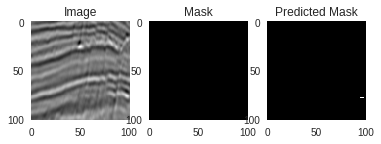

Total Loss is 0.5055148020386696, BCE loss is 0.04829079285264015, IOU loss is 0.455072820186615, IOU is 0.7133333333333333 at iter 8550, Time: 25m 26s


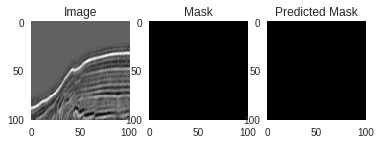

Total Loss is 0.5217657029628754, BCE loss is 0.08082905411720276, IOU loss is 0.45660537481307983, IOU is 0.5766666666666667 at iter 8600, Time: 25m 35s


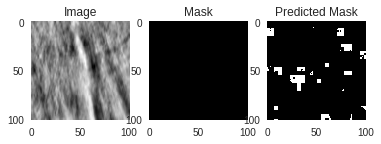

Total Loss is 0.5276024281978607, BCE loss is 0.039959125220775604, IOU loss is 0.3645641803741455, IOU is 0.7166666666666668 at iter 8650, Time: 25m 43s


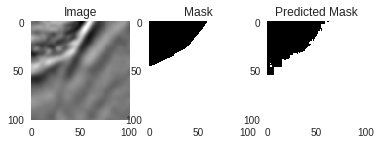

Total Loss is 0.5173393577337265, BCE loss is 0.06029888615012169, IOU loss is 0.4999462366104126, IOU is 0.5849999999999999 at iter 8700, Time: 25m 51s


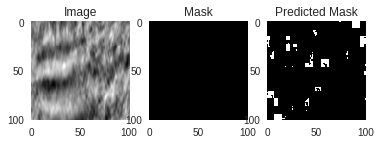

Total Loss is 0.5226521521806717, BCE loss is 0.058500129729509354, IOU loss is 0.43533855676651, IOU is 0.7150000000000001 at iter 8750, Time: 26m 0s


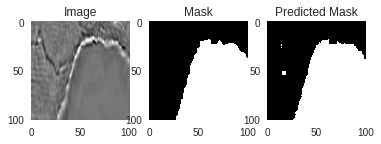

Total Loss is 0.5290827065706253, BCE loss is 0.04967762157320976, IOU loss is 0.46924877166748047, IOU is 0.6099999999999999 at iter 8800, Time: 26m 8s


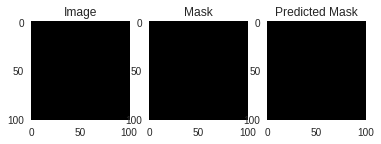

Total Loss is 0.486893492937088, BCE loss is 0.038351818919181824, IOU loss is 0.4090324640274048, IOU is 0.6933333333333334 at iter 8850, Time: 26m 16s


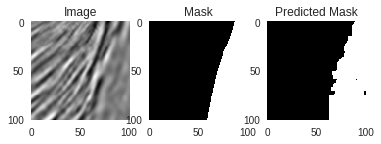

Total Loss is 0.516210886836052, BCE loss is 0.049161411821842194, IOU loss is 0.3643364906311035, IOU is 0.8 at iter 8900, Time: 26m 25s


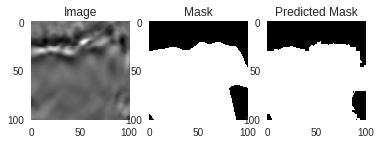

Total Loss is 0.517945072054863, BCE loss is 0.1380697786808014, IOU loss is 0.41583603620529175, IOU is 0.6983333333333334 at iter 8950, Time: 26m 33s


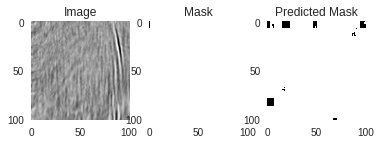

Total Loss is 0.49132087975740435, BCE loss is 0.034753549844026566, IOU loss is 0.46031177043914795, IOU is 0.635 at iter 9000, Time: 26m 41s


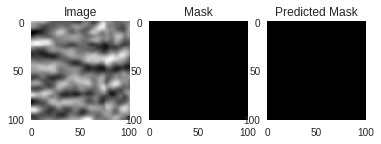

Total Loss is 0.493202643096447, BCE loss is 0.04077571630477905, IOU loss is 0.4347469210624695, IOU is 0.815 at iter 9050, Time: 26m 50s


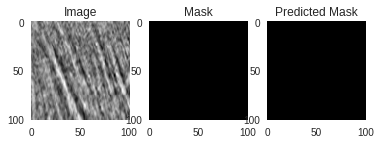

Total Loss is 0.5097786590456963, BCE loss is 0.04801369830965996, IOU loss is 0.4637923240661621, IOU is 0.6199999999999999 at iter 9100, Time: 26m 58s


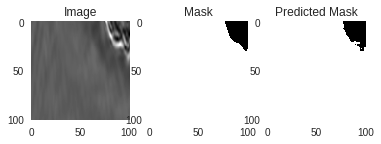

Total Loss is 0.5058376371860505, BCE loss is 0.06506352126598358, IOU loss is 0.4744183421134949, IOU is 0.5566666666666666 at iter 9150, Time: 27m 7s


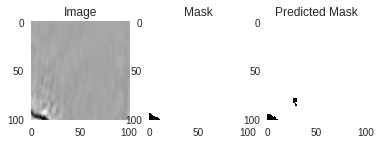

Total Loss is 0.49960158467292787, BCE loss is 0.04018599912524223, IOU loss is 0.3451491594314575, IOU is 0.7883333333333334 at iter 9200, Time: 27m 15s


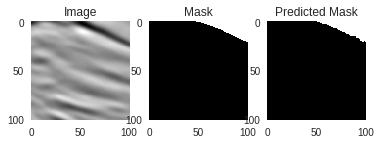

Total Loss is 0.5511368170380593, BCE loss is 0.05096080154180527, IOU loss is 0.5132090449333191, IOU is 0.5933333333333333 at iter 9250, Time: 27m 23s


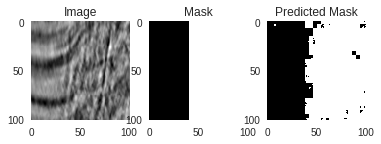

Total Loss is 0.5034719973802566, BCE loss is 0.0471561960875988, IOU loss is 0.47193819284439087, IOU is 0.5749999999999998 at iter 9300, Time: 27m 32s


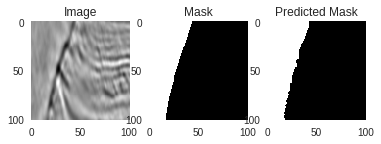

Total Loss is 0.5309889957308769, BCE loss is 0.05284925922751427, IOU loss is 0.48523157835006714, IOU is 0.6066666666666667 at iter 9350, Time: 27m 40s


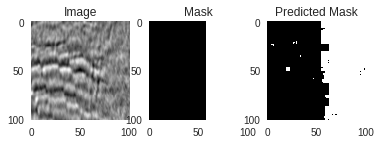

Total Loss is 0.518238665163517, BCE loss is 0.04054032266139984, IOU loss is 0.44573527574539185, IOU is 0.6916666666666667 at iter 9400, Time: 27m 48s


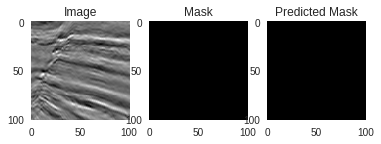

Total Loss is 0.5093964114785194, BCE loss is 0.04195382446050644, IOU loss is 0.3539031147956848, IOU is 0.7499999999999999 at iter 9450, Time: 27m 57s


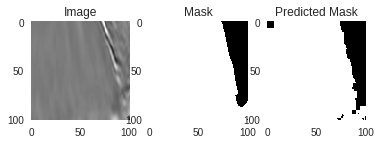

Total Loss is 0.5112018629908561, BCE loss is 0.05228777974843979, IOU loss is 0.4680967330932617, IOU is 0.7583333333333332 at iter 9500, Time: 28m 5s


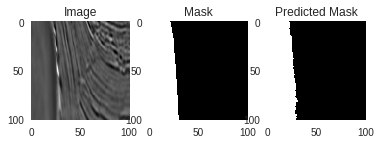

Total Loss is 0.4893632158637047, BCE loss is 0.03732970729470253, IOU loss is 0.4383639097213745, IOU is 0.6366666666666667 at iter 9550, Time: 28m 13s


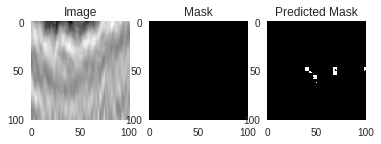

Total Loss is 0.4987795025110245, BCE loss is 0.03272935003042221, IOU loss is 0.43964242935180664, IOU is 0.6383333333333333 at iter 9600, Time: 28m 22s


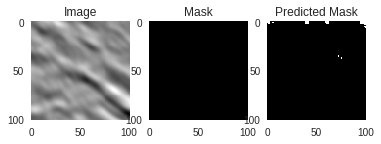

Total Loss is 0.5133513897657395, BCE loss is 0.053100213408470154, IOU loss is 0.538998007774353, IOU is 0.58 at iter 9650, Time: 28m 30s


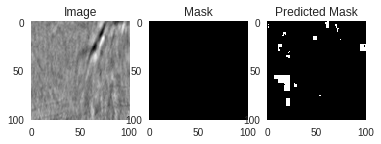

Total Loss is 0.49878341555595396, BCE loss is 0.07675310969352722, IOU loss is 0.48799771070480347, IOU is 0.645 at iter 9700, Time: 28m 38s


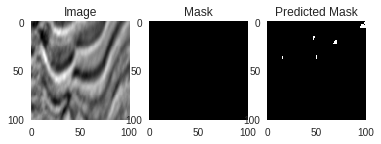

Total Loss is 0.5132936149835586, BCE loss is 0.05959233641624451, IOU loss is 0.39397871494293213, IOU is 0.7783333333333334 at iter 9750, Time: 28m 47s


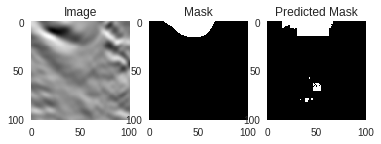

Total Loss is 0.5229861244559288, BCE loss is 0.06356487423181534, IOU loss is 0.5316299200057983, IOU is 0.5316666666666666 at iter 9800, Time: 28m 55s


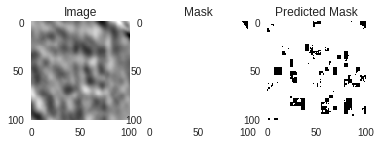

Total Loss is 0.4826431944966316, BCE loss is 0.05657782405614853, IOU loss is 0.3983426094055176, IOU is 0.755 at iter 9850, Time: 29m 3s


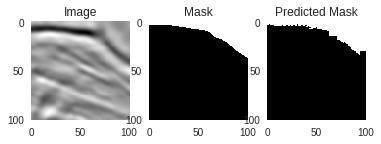

Total Loss is 0.5106289520859718, BCE loss is 0.04042964428663254, IOU loss is 0.4153868556022644, IOU is 0.6883333333333331 at iter 9900, Time: 29m 12s


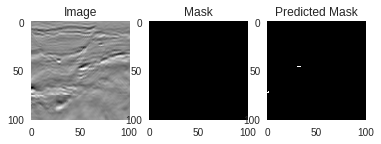

Total Loss is 0.4835063055157661, BCE loss is 0.06649501621723175, IOU loss is 0.3417152166366577, IOU is 0.7716666666666666 at iter 9950, Time: 29m 20s


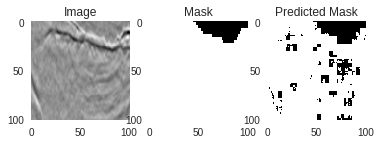

Total Loss is 0.531125956773758, BCE loss is 0.04585166275501251, IOU loss is 0.437724232673645, IOU is 0.6866666666666668 at iter 10000, Time: 29m 29s


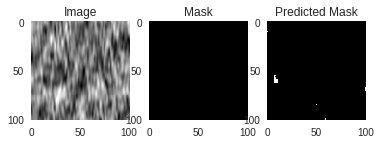

Total Loss is 0.5065349534153938, BCE loss is 0.042322251945734024, IOU loss is 0.4990207552909851, IOU is 0.5716666666666667 at iter 10050, Time: 29m 37s


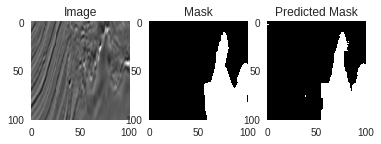

Total Loss is 0.48157599568367004, BCE loss is 0.035670701414346695, IOU loss is 0.3830416202545166, IOU is 0.7466666666666666 at iter 10100, Time: 29m 45s


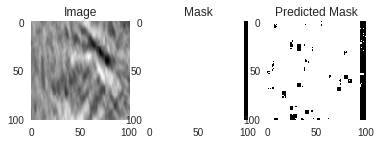

Total Loss is 0.49755452275276185, BCE loss is 0.05413811281323433, IOU loss is 0.3978237509727478, IOU is 0.7716666666666666 at iter 10150, Time: 29m 54s


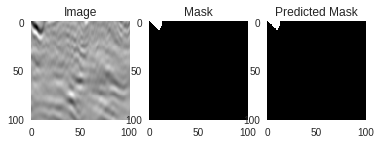

Total Loss is 0.5217414766550064, BCE loss is 0.05490326136350632, IOU loss is 0.4044194221496582, IOU is 0.7116666666666666 at iter 10200, Time: 30m 2s


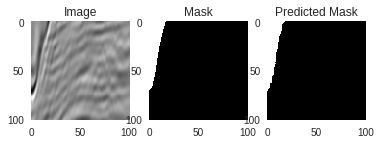

Total Loss is 0.5131541192531586, BCE loss is 0.05554947257041931, IOU loss is 0.5542625188827515, IOU is 0.4983333333333333 at iter 10250, Time: 30m 10s


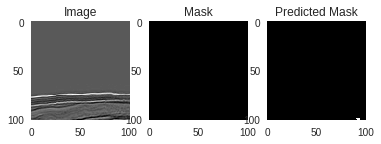

Total Loss is 0.49737204909324645, BCE loss is 0.12259551882743835, IOU loss is 0.4822036623954773, IOU is 0.6083333333333333 at iter 10300, Time: 30m 19s


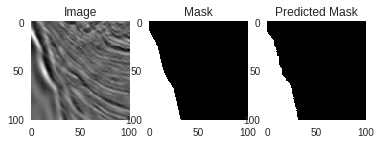

Total Loss is 0.5001807481050491, BCE loss is 0.20180673897266388, IOU loss is 0.32582902908325195, IOU is 0.7000000000000001 at iter 10350, Time: 30m 27s


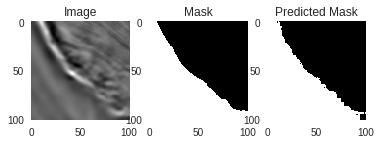

Total Loss is 0.5110859498381615, BCE loss is 0.03659532591700554, IOU loss is 0.4403678774833679, IOU is 0.6483333333333333 at iter 10400, Time: 30m 35s


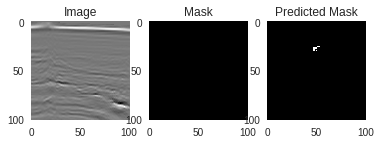

Total Loss is 0.5057525023818016, BCE loss is 0.06554226577281952, IOU loss is 0.5001839995384216, IOU is 0.6516666666666666 at iter 10450, Time: 30m 44s


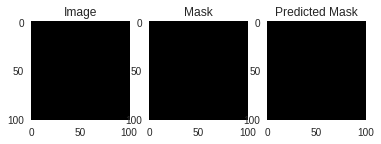

Total Loss is 0.49226644933223723, BCE loss is 0.04077007994055748, IOU loss is 0.3719820976257324, IOU is 0.7733333333333333 at iter 10500, Time: 30m 52s


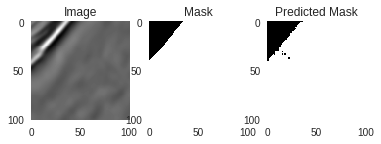

Total Loss is 0.49586818665266036, BCE loss is 0.026513569056987762, IOU loss is 0.4154583811759949, IOU is 0.6633333333333333 at iter 10550, Time: 31m 0s


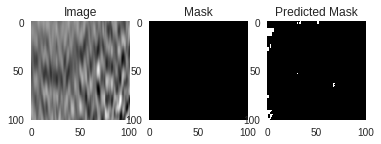

Total Loss is 0.5187680795788765, BCE loss is 0.10779891908168793, IOU loss is 0.4798952341079712, IOU is 0.705 at iter 10600, Time: 31m 9s


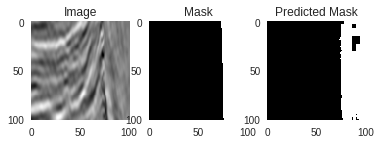

Total Loss is 0.4969901189208031, BCE loss is 0.057472363114356995, IOU loss is 0.4655139446258545, IOU is 0.6333333333333333 at iter 10650, Time: 31m 17s


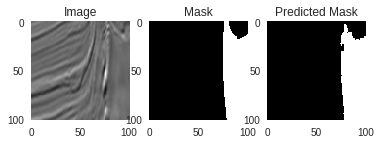

Total Loss is 0.5061782374978065, BCE loss is 0.06287970393896103, IOU loss is 0.5239801406860352, IOU is 0.6116666666666667 at iter 10700, Time: 31m 26s


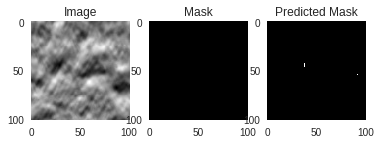

Total Loss is 0.5262069970369339, BCE loss is 0.08876995742321014, IOU loss is 0.5400662422180176, IOU is 0.5133333333333333 at iter 10750, Time: 31m 34s


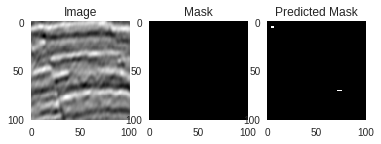

In [88]:
if TRAIN_MODE:
    for epoch in range(max_epochs):
        
        for X_batch, y_batch, d_batch, X_id in train_dataLoader:
            #y_pred = torch.tensor(saltnet(X_batch).ge(0.5).float(), requires_grad=True)

            y_pred = saltnet(X_batch)
            optimizer.zero_grad()
            loss_bce = loss_fn_bce(y_pred, y_batch.float())
            loss_iou = loss_fn_iou(y_pred, y_batch.float())
            loss = loss_bce + loss_iou
            loss.backward()
            optimizer.step()
            all_losses.append(loss.item())

            #from boxx import g
            #g()
            if iter_count % 50 == 0:
                iou_batch = calc_mean_iou(y_pred.ge(0.5).cpu(), y_batch.float().cpu())
                print(f'Total Loss is {np.mean(all_losses[-20:])}, BCE loss is {loss_bce}, IOU loss is {loss_iou}, IOU is {iou_batch} at iter {iter_count}, Time: {timeSince(start)}')
                plot_img_mask_pred(X_train[X_id[0]].squeeze(), y_train[X_id[0]].squeeze(), y_pred[0].squeeze().gt(0.5))

            iter_count+=1

In [0]:
y_pred_np = y_pred.ge(0.5).cpu().detach().numpy()

In [0]:
y_batch_np = y_batch.cpu().detach().numpy()

In [91]:
calc_raw_iou(y_pred_np, y_batch_np)

array([0.95883087, 0.        , 0.        , 1.        , 0.        ,
       0.79268293, 0.93279049, 0.97295447, 0.        , 0.94062078,
       0.90796185, 0.        , 0.        , 0.93227644, 0.91786448,
       0.97333333, 0.97080653, 0.        , 0.        , 1.        ])

In [92]:
calc_mean_iou(y_pred_np, y_batch_np)

0.5549999999999999

In [0]:
if TRAIN_MODE:
    state = {'epoch': i + 1, 'state_dict': saltnet.state_dict(),
                 'optimizer': optimizer.state_dict() }
    ckp_name = f'saltnet_{get_current_time_as_fname()}.ckp'
    torch.save(state, ckp_name)

## Load checkpoint

In [0]:
state = torch.load('saltnet_v1_20180808_0837.cpt')

In [0]:
saltnet.load_state_dict(state['state_dict'])

### Set model to evaluation mode

In [93]:
saltnet.eval()

SaltNet(
  (seq): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(10, 10))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): ReLU()
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): ReLU()
    (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
    (13): ReLU()
    (14): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): ConvTranspose

In [0]:
assert saltnet.training == False

### Make Predictions on validation set

In [0]:
val_dataLoader = DataLoader(SaltDataset(X_val, y_val, depth_val, X_train_mean_img), batch_size=800)

In [0]:
with torch.no_grad():
    for x,y,d,id in val_dataLoader:
        y_val_pred = saltnet(x)



In [0]:
y_val_pred = y_val_pred.ge(0.5).cpu().detach().numpy()

678


TypeError: ignored

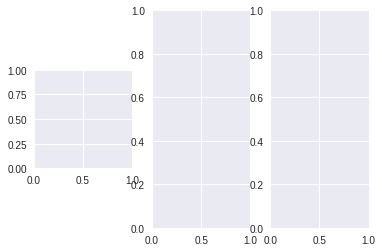

In [75]:
for i in range(10):
    rand_id = np.random.choice(len(X_val))
    print(rand_id)
    val_img = X_val[rand_id] + X_train_mean_img[:,:,None]
    val_mask = y_val[rand_id]
    val_mask_pred = y_val_pred[rand_id]
    plot_img_mask_pred(val_img, val_mask, val_mask_pred)

In [101]:
BLACK_IMG_MEAN

50

In [107]:
y_val_pred = adjust_predictions(BLACK_IMG_MEAN, 2000, X_train_mean_img.squeeze(), X_val, y_val_pred, y_val.squeeze())

IOU score before: 0.615125, IOU Score after:0.615125


In [0]:
y_val_pred = adjust_predictions(BLACK_IMG_MEAN, ZERO_MASK_CUTOFF, X_train_mean_img.squeeze(), X_val, y_val_pred, y_val.squeeze())

IOU score before: 0.44487499999999996, IOU Score after:0.62225


In [0]:
df_train['striped'] = df_train.apply(lambda x: np.any(x['mask']) & np.all(np.mod(x['mask'].sum(0),101)==0), axis=1)

In [0]:
df_train.striped.value_counts()

False    3887
True      113
Name: striped, dtype: int64

In [0]:
df_train.loc[df_train.striped].index

Index(['00950d1627', '0280deb8ae', '06d21d76c4', '09152018c4', '09b9330300',
       '0b45bde756', '130229ec15', '15d76f1672', '182bfc6862', '1eaf42beee',
       ...
       'e73ed6e7f2', 'f0c401b64b', 'f19b7d20bb', 'f641699848', 'f6e87c1458',
       'f7380099f6', 'f75842e215', 'fb3392fee0', 'fb47e8e74e', 'febd1d2a67'],
      dtype='object', name='img_id', length=113)

In [0]:
df_depth = pd.read_csv('./data/depths.csv').set_index('id')

In [0]:
df_depth.loc['00950d1627'].z

922

File name:00950d1627, depth:922


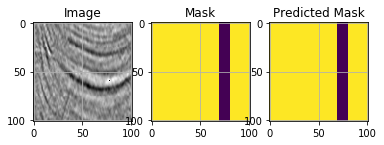

File name:0280deb8ae, depth:363


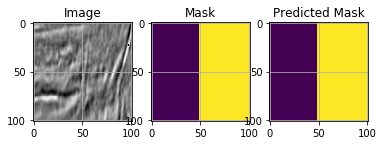

File name:06d21d76c4, depth:82


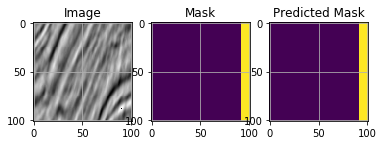

File name:09152018c4, depth:916


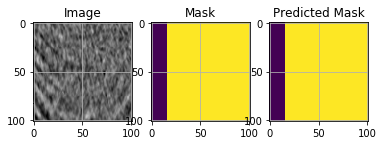

File name:09b9330300, depth:842


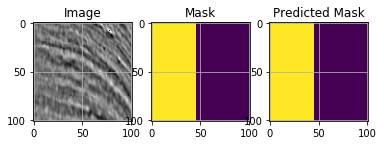

File name:0b45bde756, depth:92


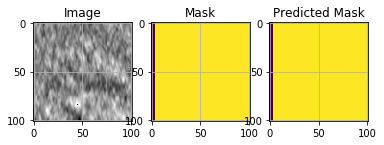

File name:130229ec15, depth:530


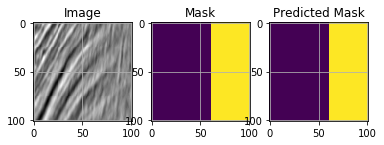

File name:15d76f1672, depth:494


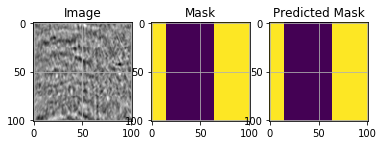

File name:182bfc6862, depth:363


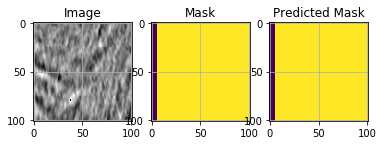

File name:1eaf42beee, depth:802


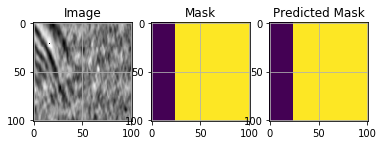

File name:23afbccfb5, depth:338


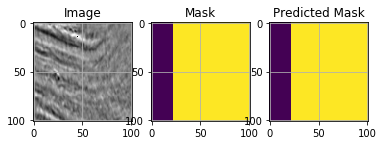

File name:24522ec665, depth:298


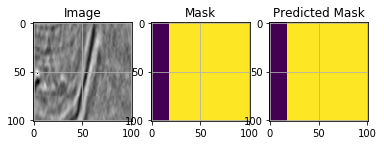

File name:285f4b2e82, depth:824


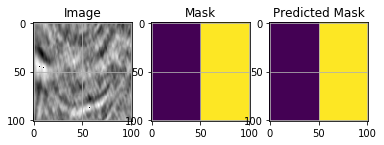

File name:2bc179b78c, depth:318


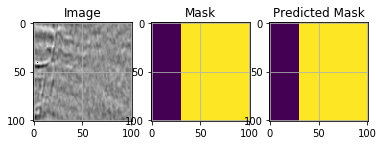

File name:2f746f8726, depth:297


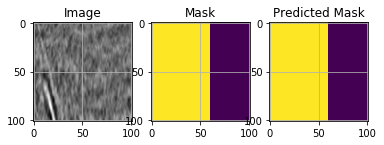

File name:33887a0ae7, depth:723


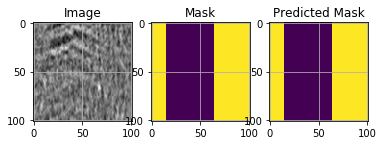

File name:33dfce3a76, depth:780


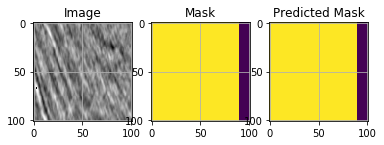

File name:3975043a11, depth:730


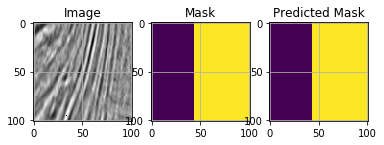

File name:39cd06da7d, depth:531


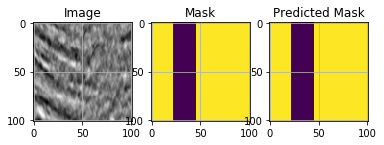

File name:3cb59a4fdc, depth:603


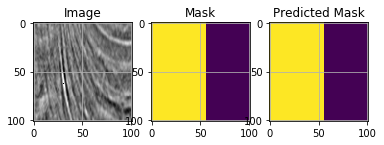

File name:403cb8f4b3, depth:661


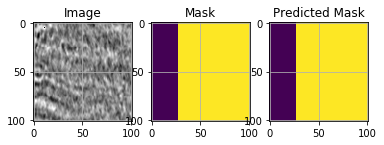

File name:483b35d589, depth:691


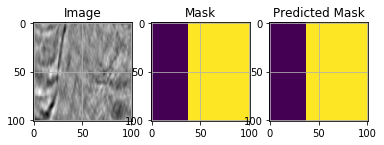

File name:49336bb17b, depth:385


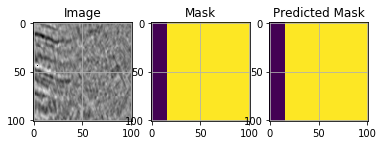

File name:4ef0559016, depth:700


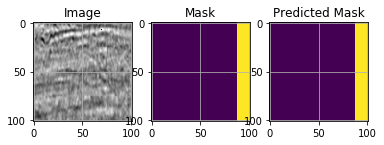

File name:4f5df40ab2, depth:514


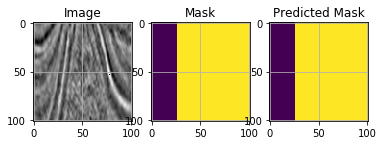

File name:4fbda008c7, depth:332


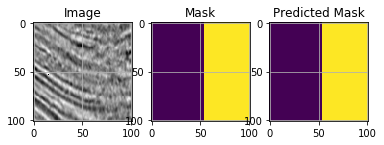

File name:4fdc882e4b, depth:955


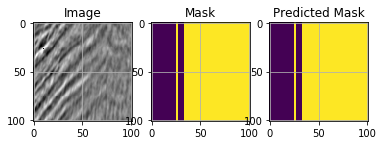

File name:50b3aef4c4, depth:116


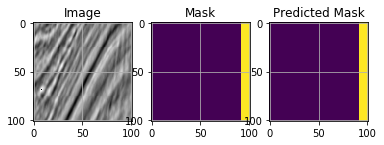

File name:50d3073821, depth:810


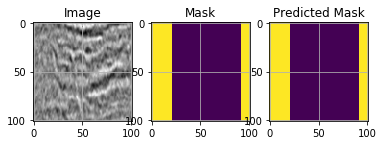

File name:52667992f8, depth:378


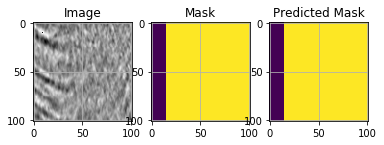

File name:52ac7bb4c1, depth:400


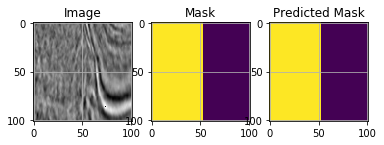

File name:53e17edd83, depth:738


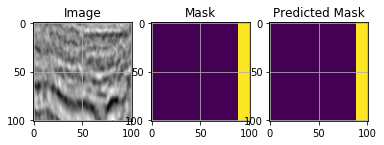

File name:56f4bcc716, depth:662


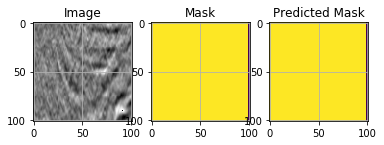

File name:58de316918, depth:901


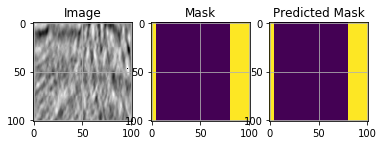

File name:5b217529e7, depth:446


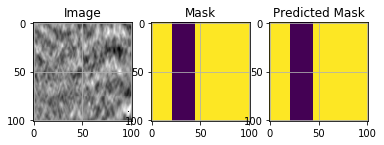

File name:5f98029612, depth:193


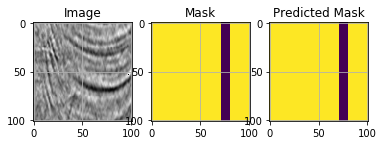

File name:608567ed23, depth:325


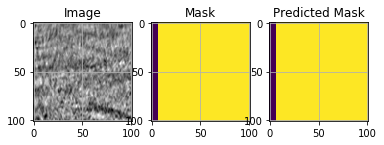

File name:62aad7556c, depth:926


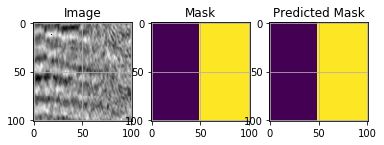

File name:62d30854d7, depth:427


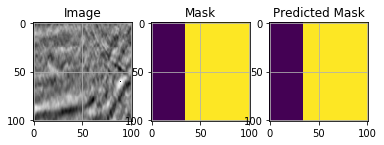

File name:640ceb328a, depth:612


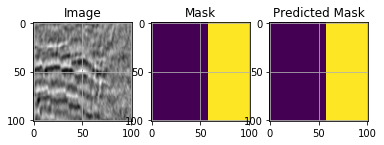

File name:6460ce2df7, depth:746


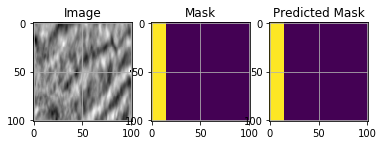

File name:6bc4c91c27, depth:655


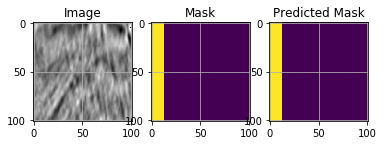

File name:71f7425387, depth:944


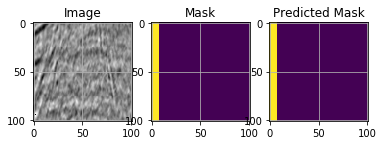

File name:7845115d01, depth:343


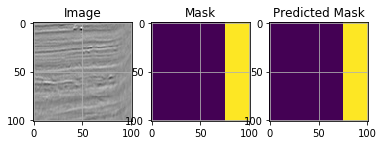

File name:7c0b76979f, depth:117


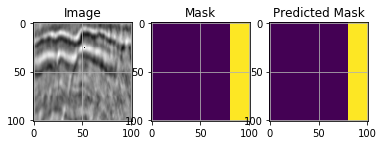

File name:7deaf30c4a, depth:365


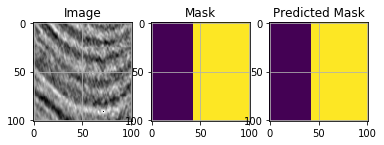

File name:7f0825a2f0, depth:136


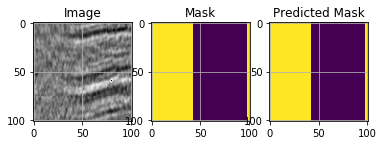

File name:80a458a2b6, depth:94


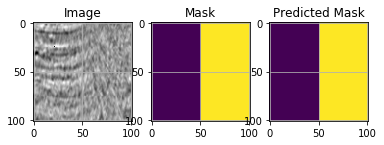

File name:81fa3d59b8, depth:857


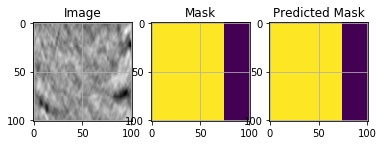

File name:834861f1b6, depth:461


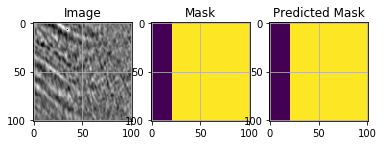

File name:8367b54eac, depth:615


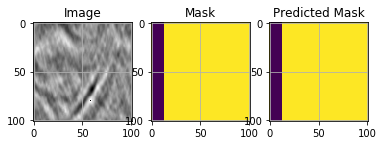

File name:849881c690, depth:701


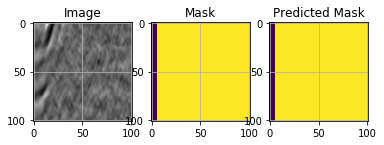

File name:876e6423e6, depth:882


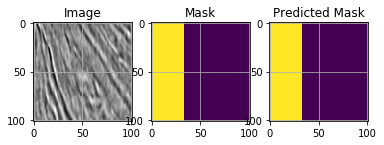

File name:87afd4b1ca, depth:668


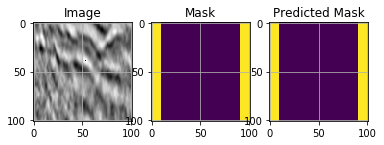

File name:88a5c49514, depth:948


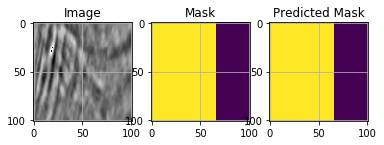

File name:9067effd34, depth:870


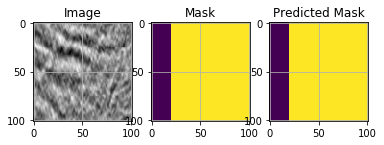

File name:90720e8172, depth:742


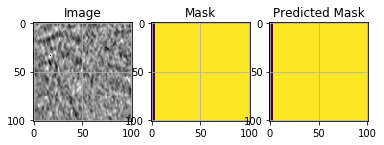

File name:916aff36ae, depth:946


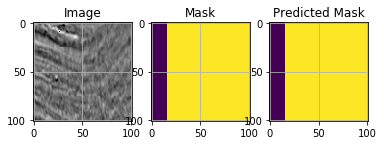

File name:919bc0e2ba, depth:352


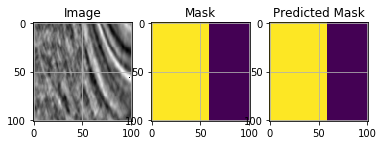

File name:93a1541218, depth:294


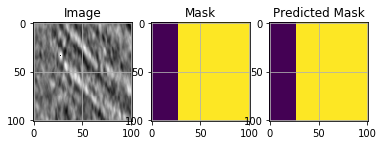

File name:95f6e2b2d1, depth:141


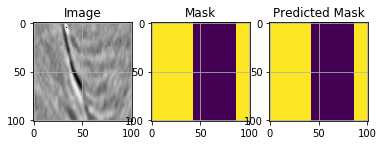

File name:96216dae3b, depth:166


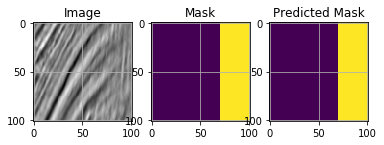

File name:96523f824a, depth:752


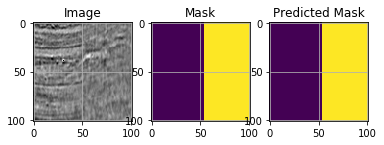

File name:99ee31b5bc, depth:241


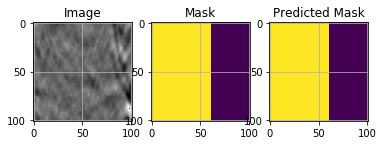

File name:9a4b15919d, depth:259


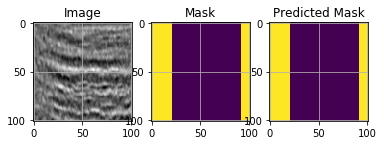

File name:9b29ca561d, depth:349


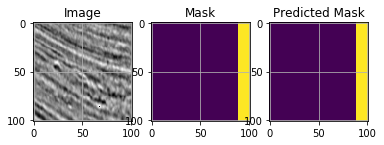

File name:9eb4a10b98, depth:581


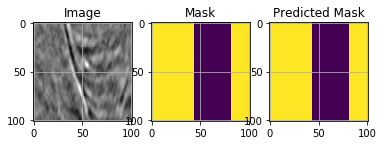

File name:a266a2a9df, depth:794


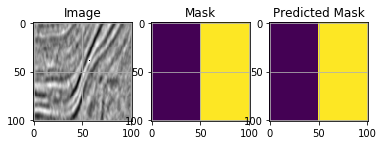

File name:a6625b8937, depth:944


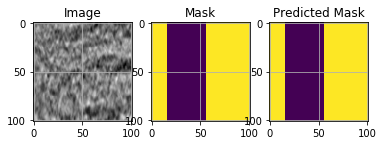

File name:a9ee40cf0d, depth:438


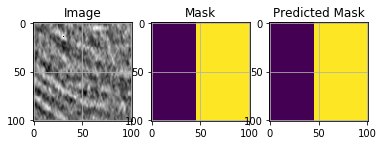

File name:ad2fa649f7, depth:858


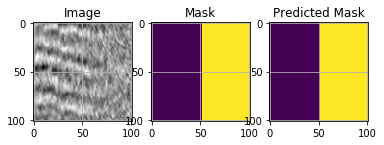

File name:aeba5383e4, depth:352


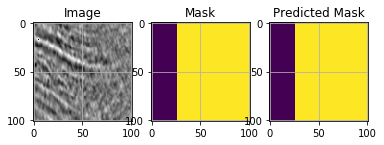

File name:b1be1fa682, depth:95


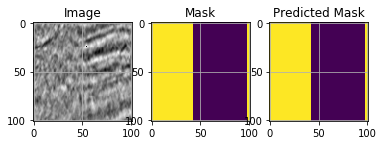

File name:b24d3673e1, depth:945


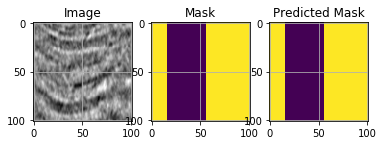

File name:b35b1b412b, depth:737


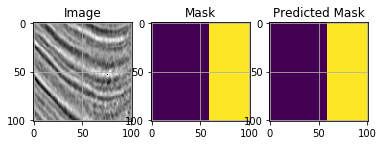

File name:b525824dfc, depth:628


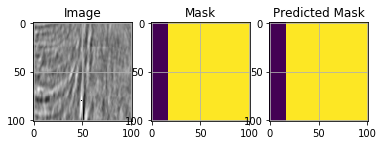

File name:b63b23fdc9, depth:194


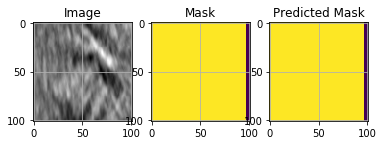

File name:b7b83447c4, depth:87


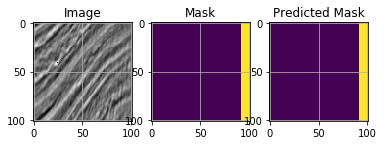

File name:b8a9602e21, depth:527


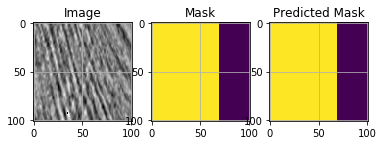

File name:ba1287cb48, depth:566


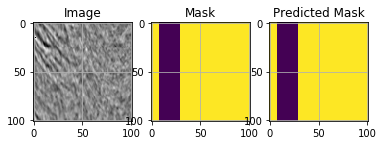

File name:baac3469ae, depth:491


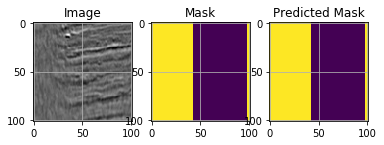

File name:be18a24c49, depth:314


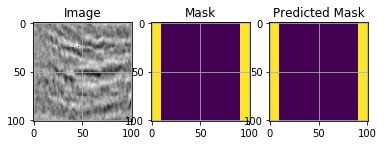

File name:be7014887d, depth:715


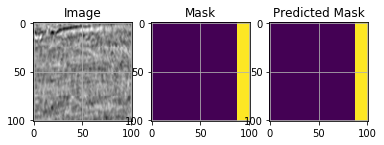

File name:be90ab3e56, depth:407


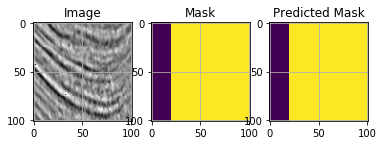

File name:bfa7ee102e, depth:844


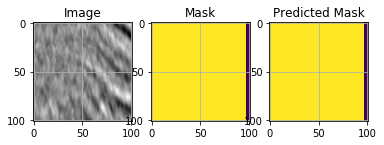

File name:bfbb9b9149, depth:802


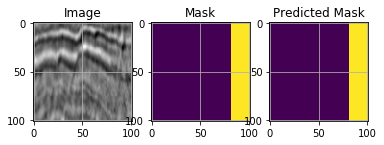

File name:c27409a765, depth:766


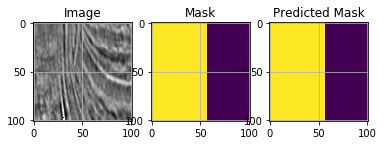

File name:c2973c16f1, depth:869


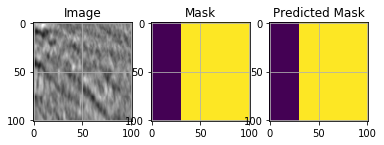

File name:c387a012fc, depth:478


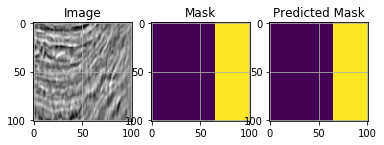

File name:c83d9529bd, depth:822


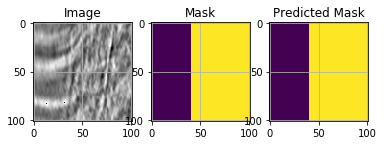

File name:c98dfd50ba, depth:558


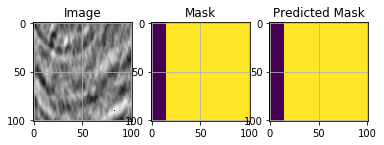

File name:caccd6708f, depth:747


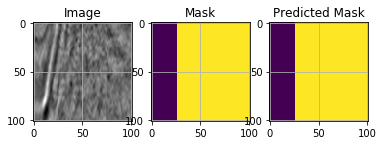

File name:cb4f7abe67, depth:183


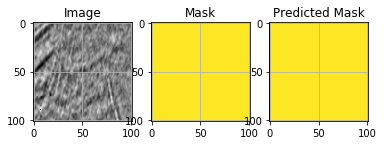

File name:cef03959d8, depth:221


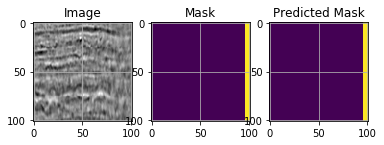

File name:d0bbe4fd97, depth:847


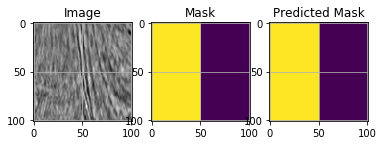

File name:d4d2ed6bd2, depth:330


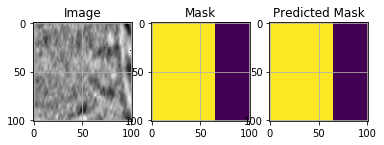

File name:d4d34af4f7, depth:114


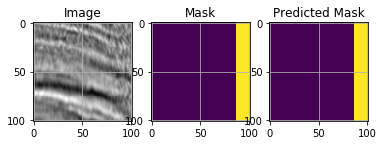

File name:d9a52dc263, depth:609


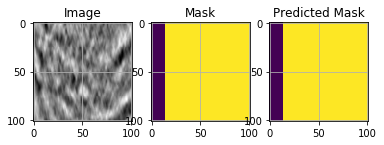

File name:dd6a04d456, depth:446


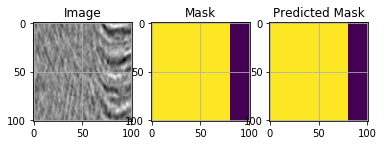

File name:ddcb457a07, depth:681


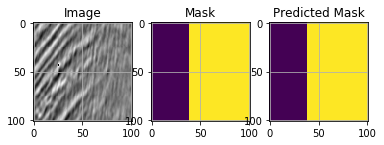

File name:de7202d286, depth:518


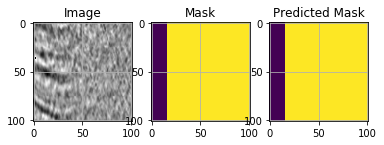

File name:e12cd094a6, depth:758


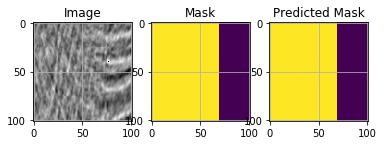

File name:e6e3e58c43, depth:448


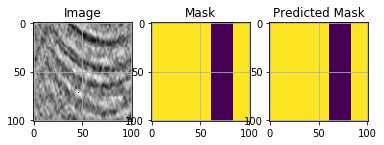

File name:e73ed6e7f2, depth:887


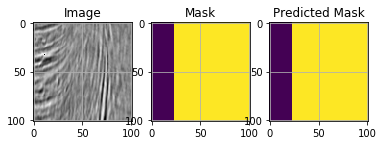

File name:f0c401b64b, depth:625


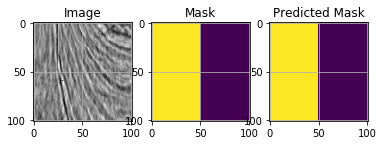

File name:f19b7d20bb, depth:451


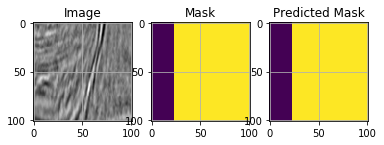

File name:f641699848, depth:552


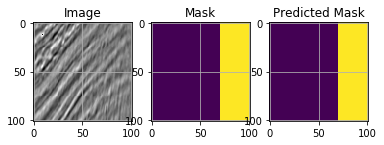

File name:f6e87c1458, depth:128


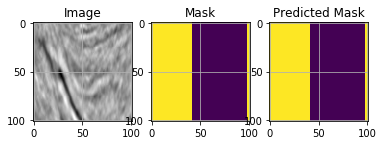

File name:f7380099f6, depth:796


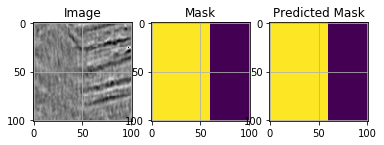

File name:f75842e215, depth:453


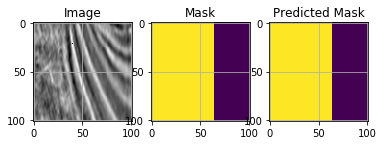

File name:fb3392fee0, depth:261


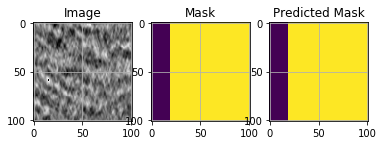

File name:fb47e8e74e, depth:757


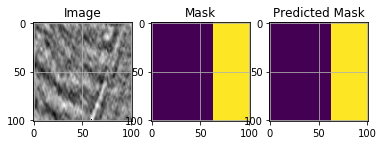

File name:febd1d2a67, depth:211


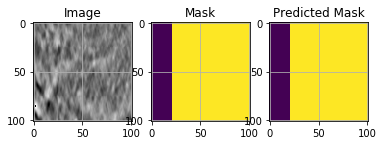

In [0]:
for i in df_train.loc[df_train.striped].index:
    #rand_id = np.random.choice(len(X_val))
    print(f'File name:{i}, depth:{df_depth.loc[i].z}')    
    img = df_train.img[i] + mean_img[:,:,None]
    mask = df_train['mask'][i]
    mask_pred = mask
    plot_img_mask_pred(img, mask, mask_pred)

## Make predictions on test set

In [0]:
y_test_pred_raw = []

In [0]:
for x in np.split(X_test, 36):
    with torch.no_grad():
        y_test_pred_raw.append(saltnet(format_train_data(x)))

In [0]:
y_test_pred_raw = torch.cat(y_test_pred_raw)

In [0]:
y_test_pred = y_test_pred_raw.ge(0.5).detach().numpy()

### Show segmentation masks for a few images

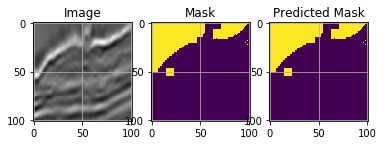

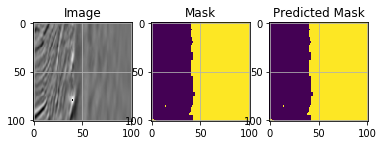

In [0]:
for i in range(2):
    rand_id = np.random.choice(len(X_test))
    #print(rand_id)
    img = X_test[rand_id] + mean_img[:,:,None]
    #mask = y_train[rand_id]
    mask_pred = y_test_pred[rand_id]
    plot_img_mask_pred(img, mask_pred, mask_pred)

### Adjust predictions

In [0]:
y_test_pred = adjust_predictions(BLACK_IMG_MEAN, ZERO_MASK_CUTOFF, mean_img, X_test, y_test_pred)

### Encode predictions using RLE(Run Length Encoding) method

In [0]:
y_test_pred_rle = rle_encoder3d(y_test_pred)

In [0]:
df_test_rle = pd.DataFrame(index=df_test.index, data=y_test_pred_rle).reset_index()

In [0]:
df_test_rle.columns = ['id', 'rle_mask']

In [0]:
df_test_rle[df_test_rle.rle_mask==''].shape

(6665, 2)

In [0]:
df_test_rle.to_csv(f'submission_{get_current_time_as_fname()}.csv', index=False)